# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# # Run this to use from colab environment
# !git clone https://github.com/jveenland/tm10007_ml.git

# import zipfile
# import os
# import pandas as pd

# with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/tm10007_ml/ecg')

# data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

# print(f'The number of samples: {len(data.index)}')
# print(f'The number of columns: {len(data.columns)}')

In [7]:
# Run this to use from colab environment
# !git clone https://github.com/jveenland/tm10007_ml.git

# Standard libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

# Statistical tools
from scipy.stats import zscore, normaltest, shapiro

# Scikit-learn
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.metrics import RocCurveDisplay, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, RFECV, RFE, f_classif, mutual_info_classif

# Classifiers and dimensionality reduction
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Load data
with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Set RandomState for the entire script
np.random.seed(42)

The number of samples: 827
The number of columns: 9001


In [8]:
# Load functions
def plot_learning_curve(X_train, y_train, classifier, scoring, clf_type):
    '''
    This function plots the learning curve of a classifier using a 5-fold cross-validation
    Inputs:
    - X_train: 
    - y_train: labels
    - classifier: fitted classifier
    - scoring: supports all scoring methods from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html 
    and the 'error' scoring method, which is 1-accuracy
    - clf_type: is used for the title of the plot
    '''
    if scoring == 'error':
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1,
        )
        train_scores_mean = 1-np.mean(train_scores, axis=1) # error = 1 - accuracy
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = 1-np.mean(test_scores, axis=1) # error = 1 - accuracy
        test_scores_std = np.std(test_scores, axis=1)
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1,
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

    # Plot figure
    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve ({clf_type})")
    plt.xlabel("Number of training objects")
    plt.ylabel(scoring)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="blue")

    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="green")

    plt.legend(loc="best")
    if scoring == 'error':
        plt.ylim([-0.01, 0.5])
    elif scoring == 'roc_auc':
        plt.ylim([0.5, 1.01])
    plt.tight_layout()
    plt.show()

def plot_roc_cv(X, y, hyperparams_function, n_splits=5):
    '''
    Performs a cross validation to train a number of models (equal to n_splits), calculates relevant metrics and plots the mean ROC curve.
    Returns the best classifier out of the folds with the corresponding training data
    '''
    y = data.iloc[:,-1]
    X = data.iloc[:,:-1]

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    tprs = []
    aucs = []
    best_classifier = None
    best_auc = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        classifier = hyperparams_function(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        if viz.roc_auc > best_auc:
            best_auc = viz.roc_auc
            best_classifier = classifier
            best_X_train = X_train
            best_y_train = y_train

        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        fold_auc = roc_auc_score(y_test, y_proba)

        print(f"Accuracy:  {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall:    {recall:.3f}")
        print(f"F1 Score:  {f1:.3f}")
        print(f"AUC Score: {fold_auc:.3f}")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability",
    )
    ax.legend(loc="lower right")
    plt.show()
    return best_X_train, best_y_train, best_classifier


# Data visualisation

Number of healthy samples: 681
Total number of samples: 827


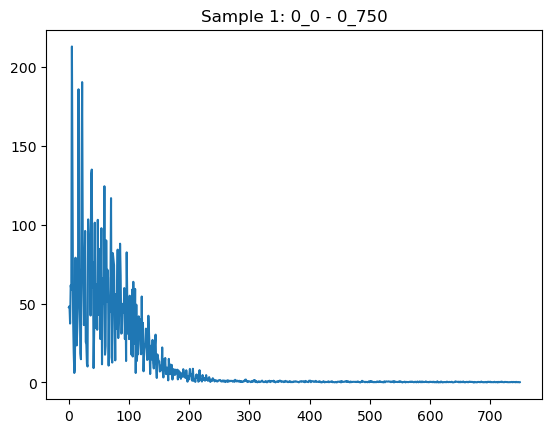

In [9]:
# print number of sick and not sick --> to determine scoring method
count = 0
for label in data.iloc[:,-1]:
    if label == 0:
        count += 1

print(f"Number of healthy samples: {count}")
print(f"Total number of samples: {len(data.iloc[:,-1])}")

# All data of sample 1, lead 1 was plotted to get a quick overview of the data
fig, ax = plt.subplots(1,1)
ax.plot(range(0,750), data.iloc[0,0:750])
ax.set_title('Sample 1: 0_0 - 0_750')
plt.show()

#This plot shows that the data is not normally distributed 

In [6]:
# Check for missing values
missing_values = data.isna().sum()

if missing_values.sum() > 0:
    print("Missing values found:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values found.")

No missing values found.


Check for zero values in dataset for possible log transform

In [98]:
# Check if there are any zero values in the entire DataFrame
zero_values = (data.iloc[:,:-1] == 0)
print("Zero values present in the DataFrame:\n", zero_values)

# Count the number of zero values
num_zero_values = zero_values.sum().sum()
print(f"Total number of zero values: {num_zero_values}")

Zero values present in the DataFrame:
        0_0    0_1    0_2    0_3    0_4    0_5    0_6    0_7    0_8    0_9  \
0    False  False  False  False  False  False  False  False  False  False   
1    False  False  False  False  False  False  False  False  False  False   
2    False  False  False  False  False  False  False  False  False  False   
3    False  False  False  False  False  False  False  False  False  False   
4    False  False  False  False  False  False  False  False  False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
822  False  False  False  False  False  False  False  False  False  False   
823  False  False  False  False  False  False  False  False  False  False   
824  False  False  False  False  False  False  False  False  False  False   
825  False  False  False  False  False  False  False  False  False  False   
826  False  False  False  False  False  False  False  False  False  False   

     ...  11_740  11_741  11_742  11

### PCA
Look at correlation heatmap to see if PCA is needed

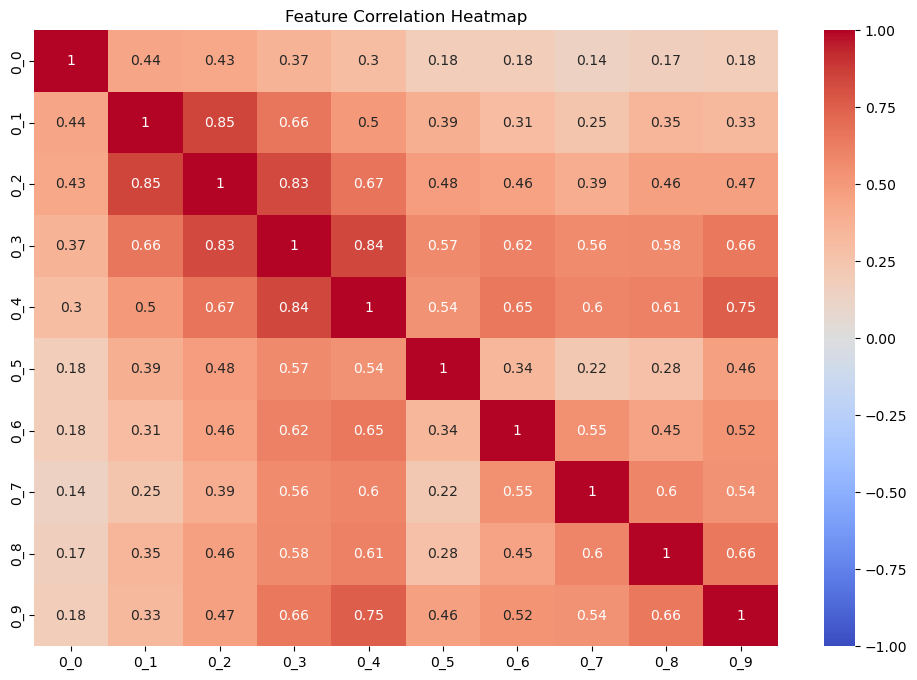

In [ ]:
# Compute correlation matrix
correlation_matrix = X_train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.iloc[:10, :10], cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

Look at PCA when scaling is applied

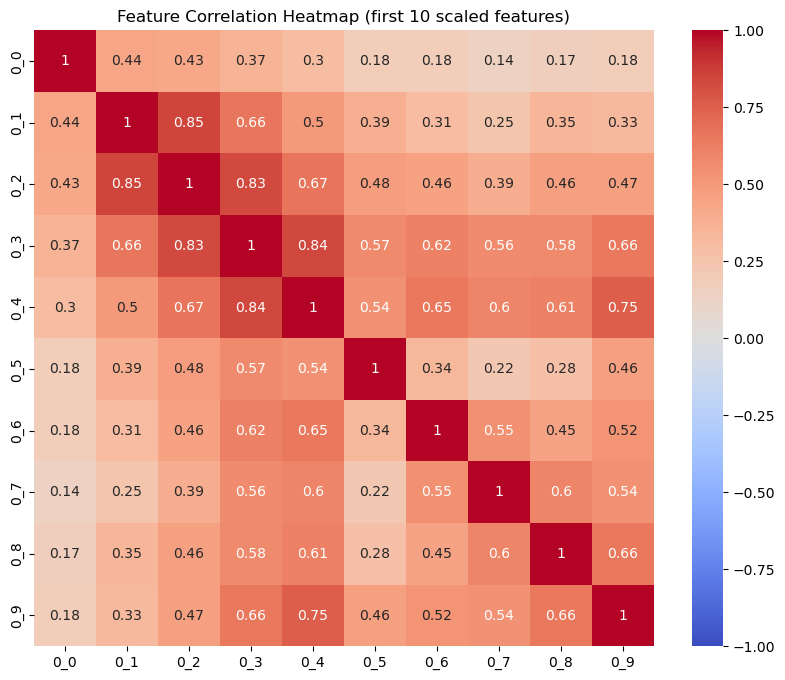

In [ ]:
# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Heatmap van correlaties op geschaalde data (eerste 10 features)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
correlation_matrix = X_train_scaled_df.iloc[:, :10].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=True)
plt.title("Feature Correlation Heatmap (first 10 scaled features)")
plt.show()

# PCA - retain 95% variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)


In [ ]:
# PCA without scaling
pca_unscaled = PCA(n_components=0.95)
X_train_pca_unscaled = pca_unscaled.fit_transform(X_train)

print("Aantal componenten met scaling:", X_train_pca.shape[1])
print("Aantal componenten zonder scaling:", X_train_pca_unscaled.shape[1])


Aantal componenten met scaling: 113
Aantal componenten zonder scaling: 14


### Testing for normality & outliers

Normal Features: 0
Non-Normal Features: 9001
Transformed Normal Features: 300
Transformed Non-Normal Features: 8701


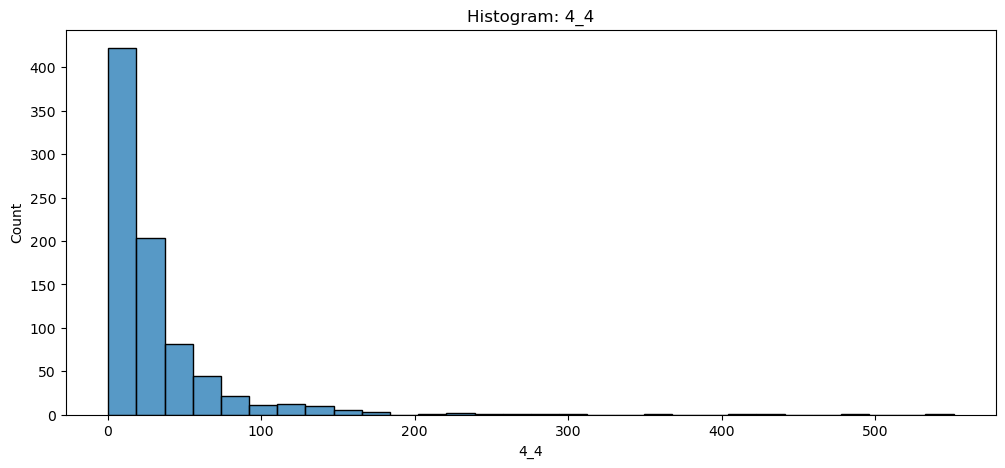

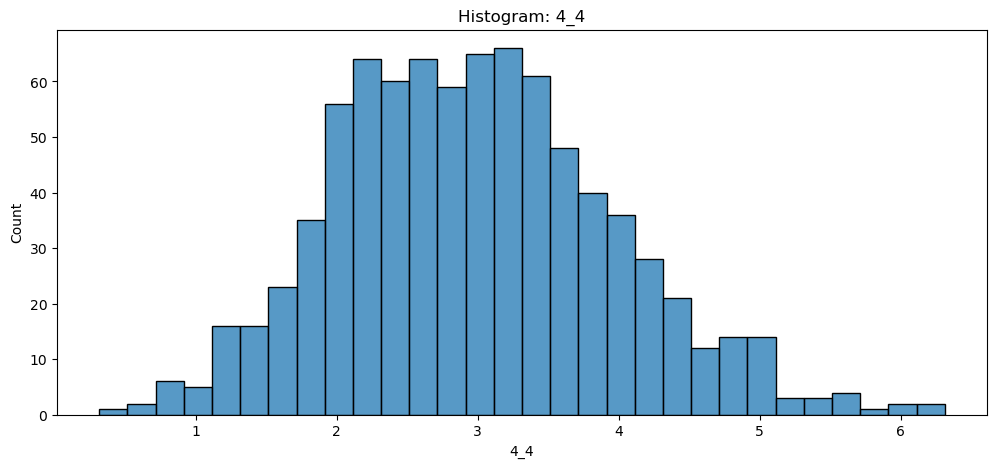

In [6]:
normal_features = []
non_normal_features = []

for feature in data.columns:
    stat, p = shapiro(data[feature]) # Or use normaltest()
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

t_normal_features = []
t_non_normal_features = []
data_transformed = np.log1p(data)
for feature in data_transformed.columns:
    stat, p = shapiro(data_transformed[feature]) # Or use normaltest()
    if p > 0.05:
        t_normal_features.append(feature)
    else:
        t_non_normal_features.append(feature)

print(f"Transformed Normal Features: {len(t_normal_features)}")
print(f"Transformed Non-Normal Features: {len(t_non_normal_features)}")


def plot_normality(feature_data, feature_name):
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.plot()
    sns.histplot(feature_data, bins=30)
    plt.title(f"Histogram: {feature_name}")

    plt.show()

plot_normality(data['4_4'], '4_4')
plot_normality(data_transformed['4_4'], '4_4')

(207, 9000)
(620, 9000)


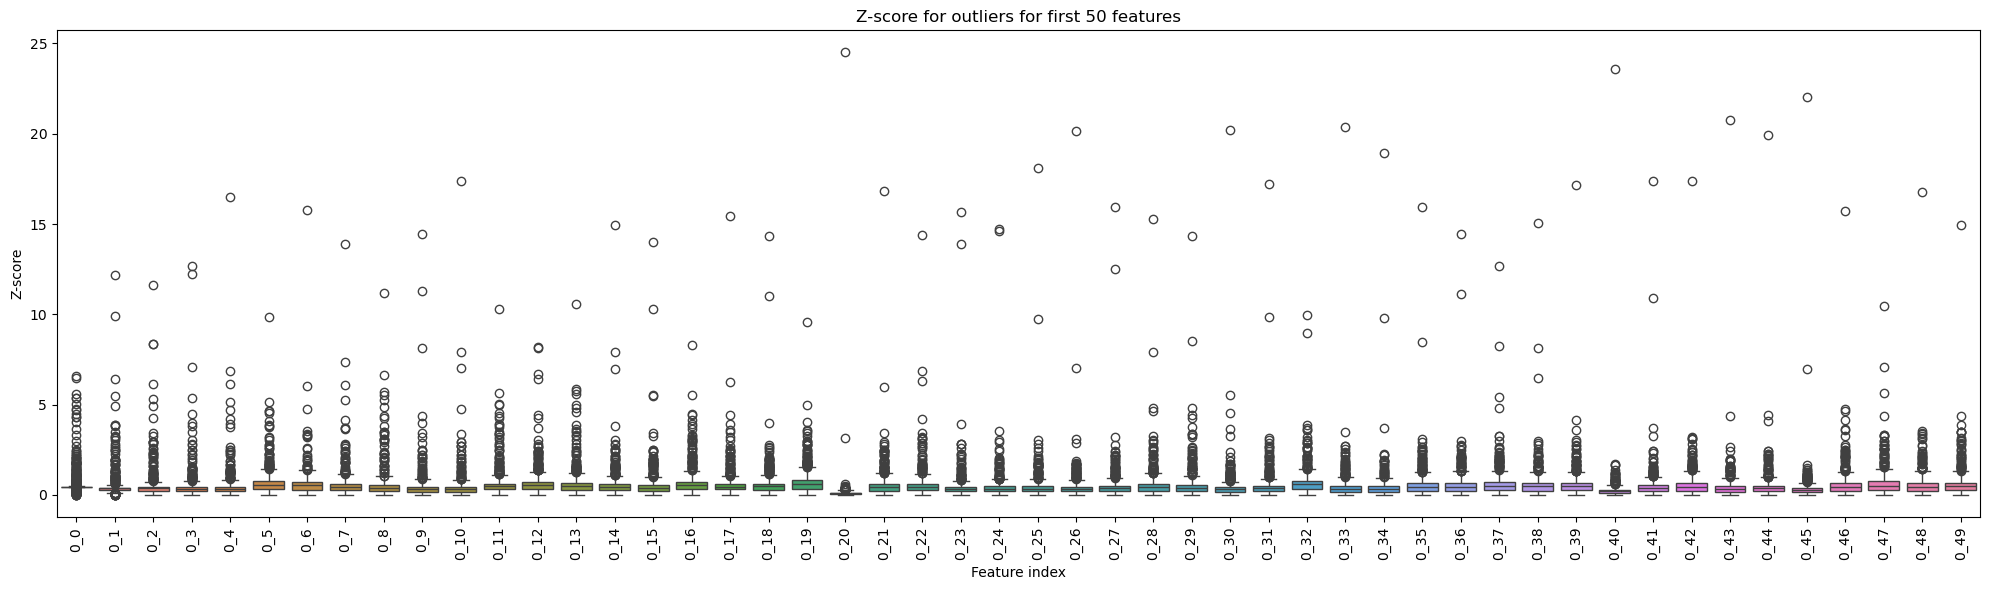

In [8]:
# The following code was used to check whether the data contained outliers. 
# This was done by plotting the Z-score for the first 50 features.
# From the resulting plot, it can be concluded that there are outliers (Z-score > 3) 
# and that the data should be scaled before training classifiers that are sensitive to outliers
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)
print(X_test.shape)
print(X_train.shape)

#Preprocessing, scaling: outliers plotten for first 50 features
X_subset = X_train.iloc[:, :50]
z_scores = np.abs(zscore(X_subset))

plt.figure(figsize=(20, 6))
sns.boxplot(data=pd.DataFrame(z_scores, columns=X_subset.columns))
plt.title("Z-score for outliers for first 50 features")
plt.xlabel("Feature index")
plt.ylabel("Z-score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Check outliers after powertransform

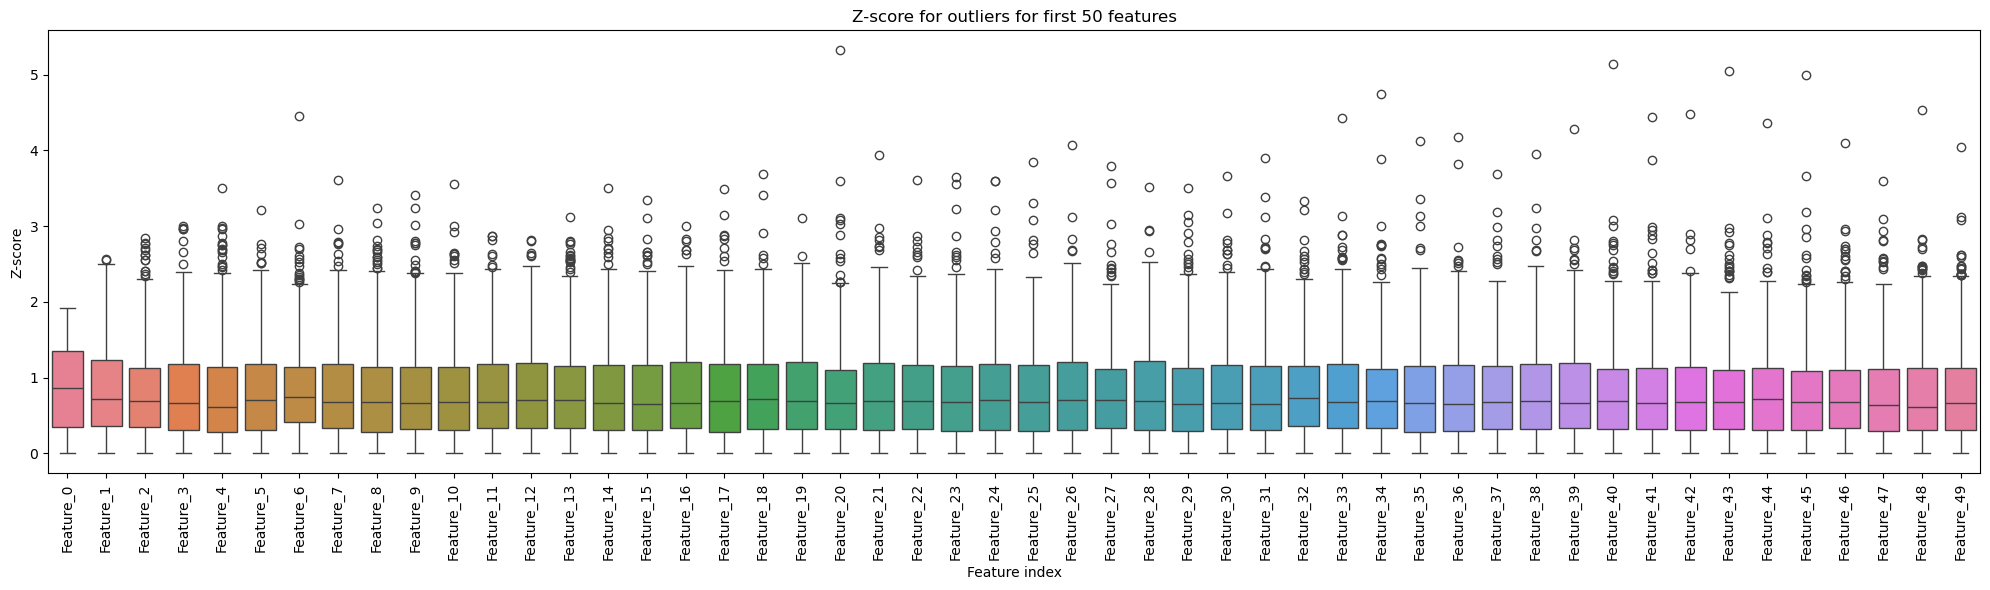

In [8]:
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

X_subset = X_train_transformed[:, :50]
z_scores = np.abs(zscore(X_subset))

z_df = pd.DataFrame(z_scores, columns=[f'Feature_{i}' for i in range(X_subset.shape[1])])

plt.figure(figsize=(20, 6))
sns.boxplot(data=z_df)
plt.title("Z-score for outliers for first 50 features")
plt.xlabel("Feature index")
plt.ylabel("Z-score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

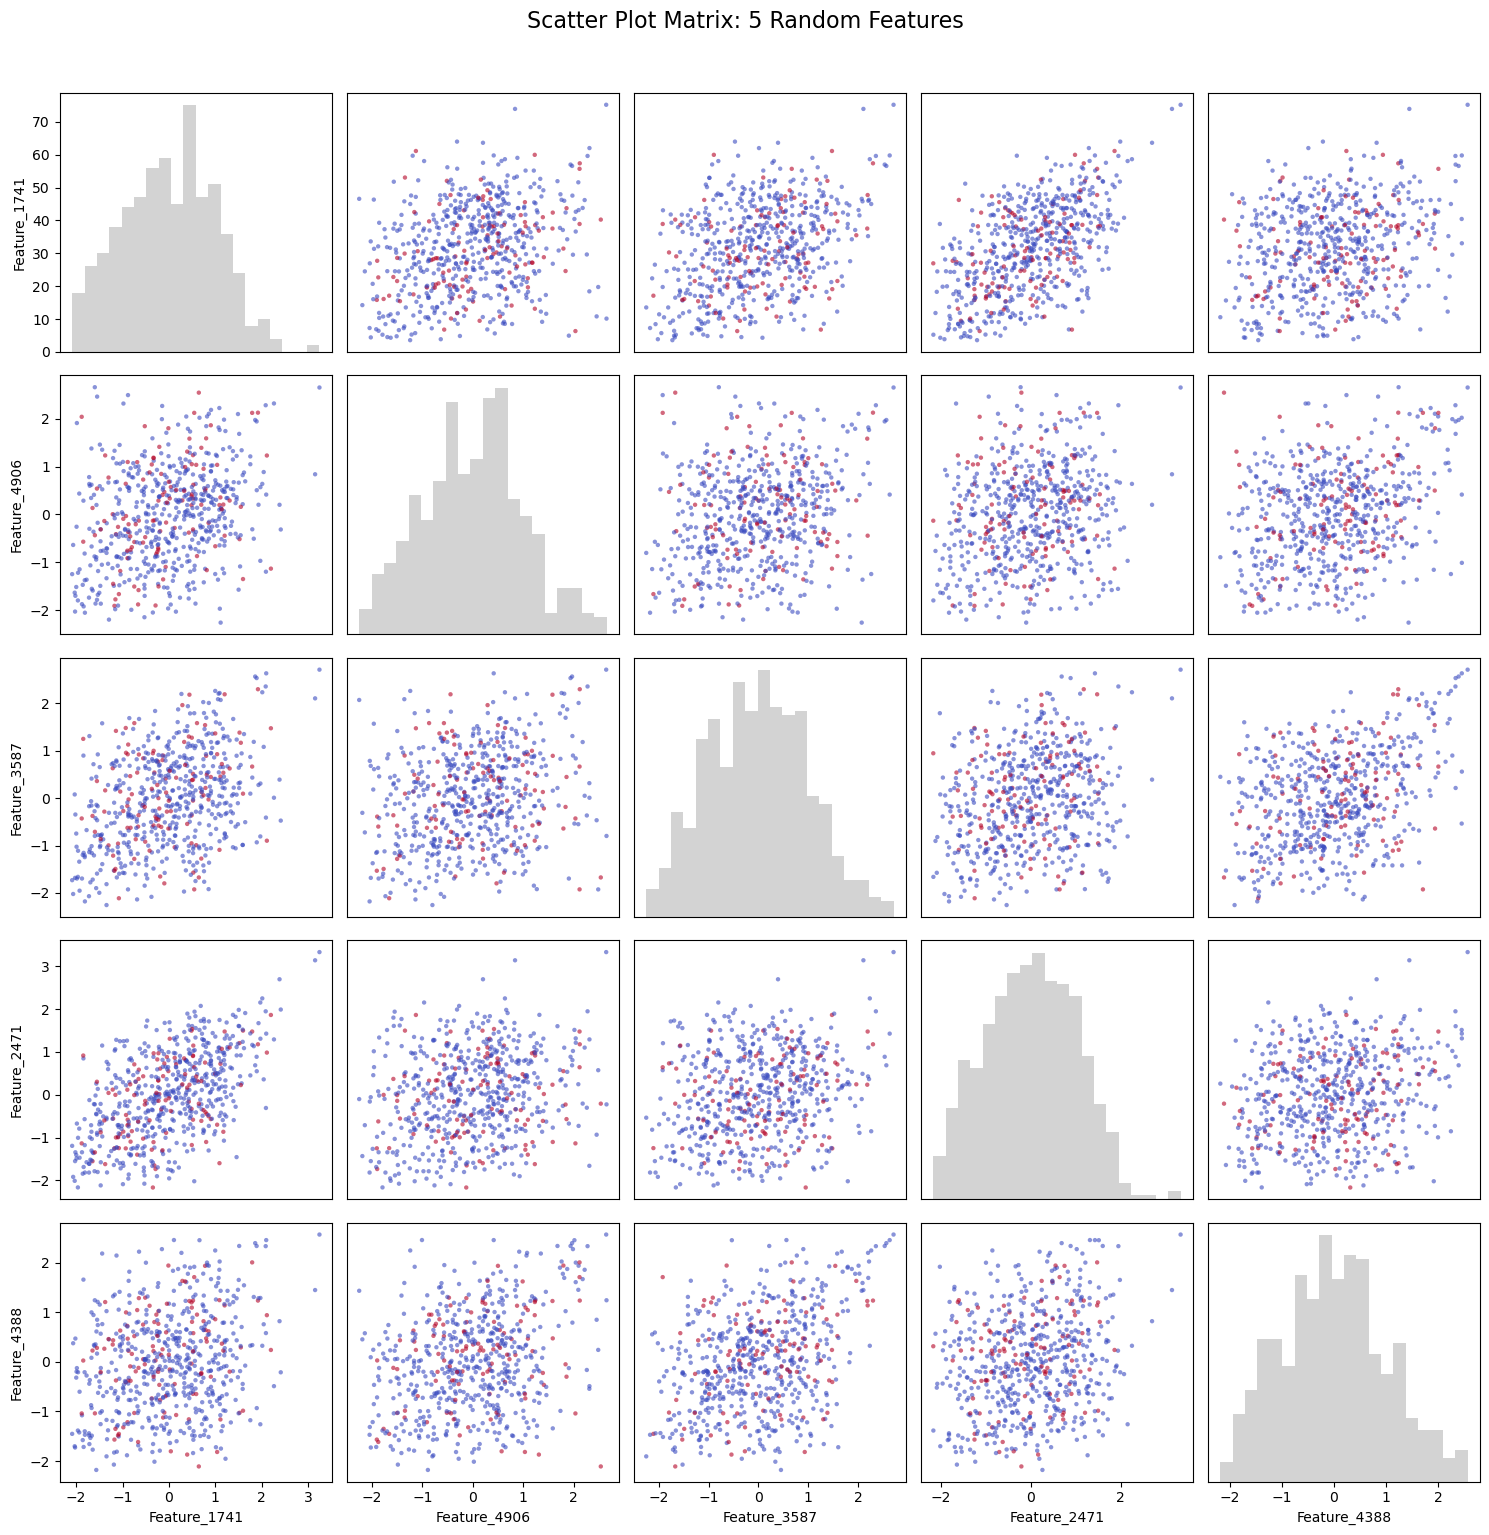

In [45]:
# Check distribution of data after powertransform
# Pick 5 random features
random_features = np.random.choice(X_train_transformed.shape[1], size=5, replace=False)

# Subset the data
X_subset = X_train_transformed[:, random_features]
feature_names = [f'Feature_{i}' for i in random_features]

# Create figure
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle("Scatter Plot Matrix: 5 Random Features", fontsize=16, y=1.02)

# Fill the grid
for i in range(5):
    for j in range(5):
        ax = axes[i, j]
        if i == j:
            # Plot histogram on the diagonal
            ax.hist(X_subset[:, i], bins=20, color='lightgray')
        else:
            # Scatter plot
            ax.scatter(
                X_subset[:, j], X_subset[:, i],
                c=y_train, cmap='coolwarm', s=10, alpha=0.6, edgecolors='none'
            )
        if i == 4:
            ax.set_xlabel(feature_names[j])
        else:
            ax.set_xticks([])
        if j == 0:
            ax.set_ylabel(feature_names[i])
        else:
            ax.set_yticks([])

plt.tight_layout()
plt.show()

#### Unused code for normality analysis

In [29]:
# How many features are normally distributed with and without transformation?
normal_features = []
non_normal_features = []

for feature in X_train.columns:  
    stat, p = shapiro(X_train[feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

t_normal_features = []
t_non_normal_features = []

data_transformed = np.log1p(X_train)
for feature in data_transformed.columns: 
    stat, p = shapiro(data_transformed[feature])  
    if p > 0.05:
        t_normal_features.append(feature)
    else:
        t_non_normal_features.append(feature)

print(f"Transformed Normal Features: {len(t_normal_features)}")
print(f"Transformed Non-Normal Features: {len(t_non_normal_features)}")

Normal Features: 0
Non-Normal Features: 9000
Transformed Normal Features: 400
Transformed Non-Normal Features: 8600


When selecting the best 400 features are these normally distributed? Method: mutual_info_classif and RFECV

In [35]:
# Select top 400 features with the highest F-statistic
selector = SelectKBest(score_func=mutual_info_classif, k=400)
X_train_selected = selector.fit_transform(X_train, y_train)

# Use LDA as the estimator (since it's similar to QDA but more stable for feature selection)
lda = LinearDiscriminantAnalysis()  # LDA as a baseline for QDA

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(estimator=lda, step=1, cv=cv, scoring='accuracy', n_jobs=-1)
X_train_final = rfecv.fit_transform(X_train_selected, y_train)
X_train_final = np.log1p(X_train_final)

# Check normality
normal_features = []
non_normal_features = []

for feature in range(X_train_final.shape[1]):
    stat, p = shapiro(X_train_final[:, feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

Normal Features: 0
Non-Normal Features: 7


When selecting the best 400 features are these normally distributed? Method: mutual_info_classif and RFE

In [34]:
# Select top 400 features with the highest F-statistic
selector = SelectKBest(score_func=mutual_info_classif, k=400)
X_train_selected = selector.fit_transform(X_train, y_train)

# Use LDA as the estimator (since it's similar to QDA but more stable for feature selection)
lda = LinearDiscriminantAnalysis()  # LDA as a baseline for QDA

rfe = RFE(estimator=lda, n_features_to_select=100)
X_train_final = rfe.fit_transform(X_train_selected, y_train)
X_train_final = np.log1p(X_train_final)

# Check normality
normal_features = []
non_normal_features = []

for feature in range(X_train_final.shape[1]):
    stat, p = shapiro(X_train_final[:, feature])
    if p > 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)

print(f"Normal Features: {len(normal_features)}")
print(f"Non-Normal Features: {len(non_normal_features)}")

Normal Features: 0
Non-Normal Features: 100


# SVM

In [109]:
# Split data in test and train, do this once
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

# ====== PIPELINE CHARACTERISTICS ======
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_feature = SVC(kernel="linear", random_state=42, class_weight='balanced')

With this code, a learning curve for robust and powertransform was made to make a choise between the scaling/transforming method

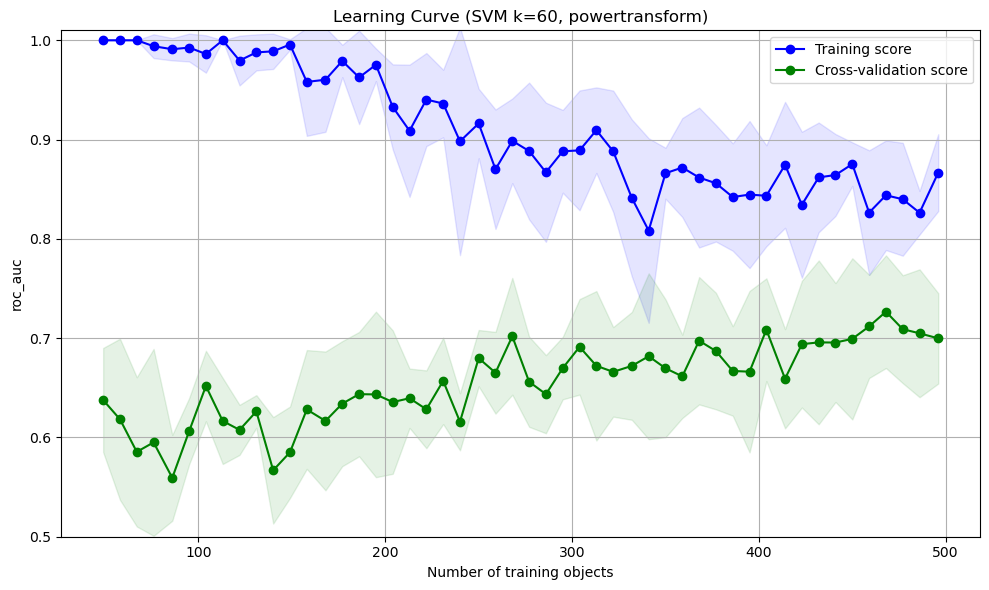

Mean ROC AUC: 0.7032144896793668


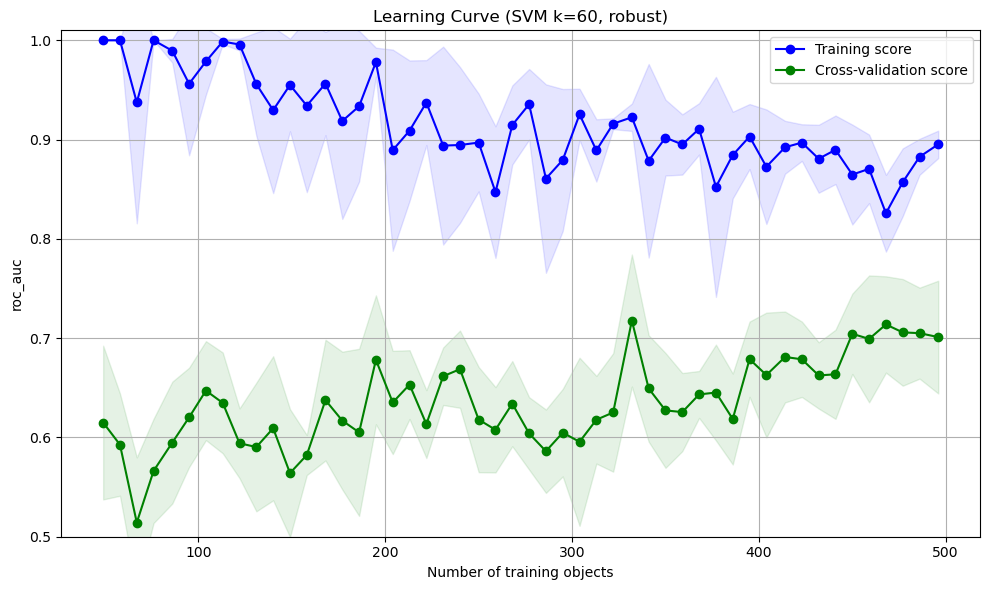

Mean ROC AUC: 0.6579199022945453


In [81]:
# Powertransform
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('select_k_best', SelectKBest(mutual_info_classif, k=60)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_train, y_train)
plot_learning_curve(X_train, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=60, powertransform')
print("Mean ROC AUC:", scores.mean())


# robust scaling
# ====== PIPELINE CHARACTERISTICS ======
svm_feature = SVC(kernel="linear", random_state=42, class_weight='balanced')

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('select_k_best', SelectKBest(mutual_info_classif, k=60)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_train, y_train)
plot_learning_curve(X_train, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=60, robust')
print("Mean ROC AUC:", scores.mean())

To select the best k for SelectKBest, a learning curve is plotted for K=100, K=80, K=60, K=40 and K=20. In addition, the number of selected features after RFECV and the mean ROC AUC is printed. This is done with transformation and feature selection outside the pipeline, for computational reasons. 

In [110]:
# ====== Powertransformation ======
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

The plot for K=100 has changed due to an extra run, see the report for the plot where the K-selection was based on

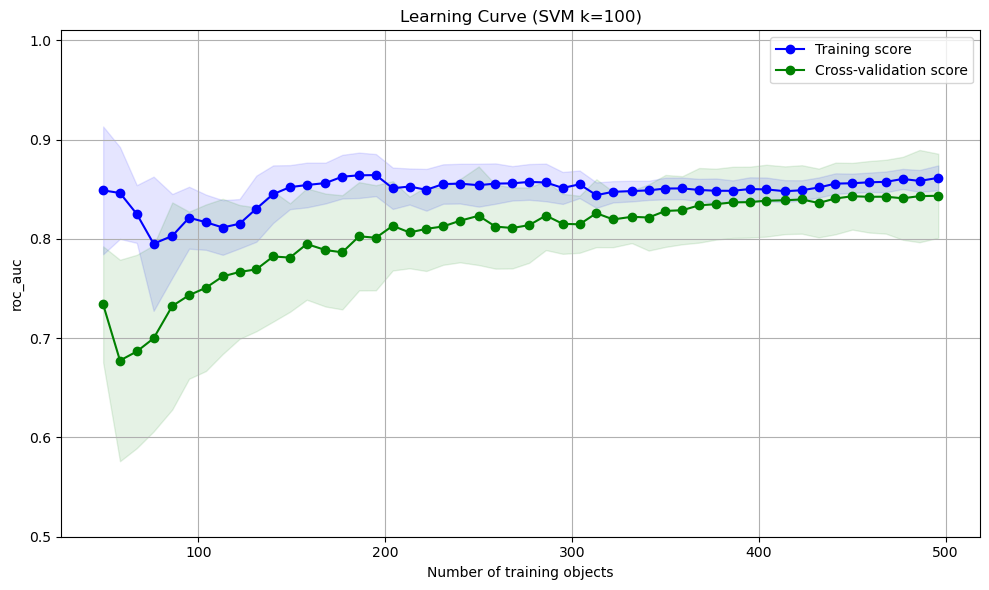

Number of Features Selected after RFECV: 15
Mean ROC AUC: 0.843375708624138


In [ ]:
# K = 100
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=100)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=100')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

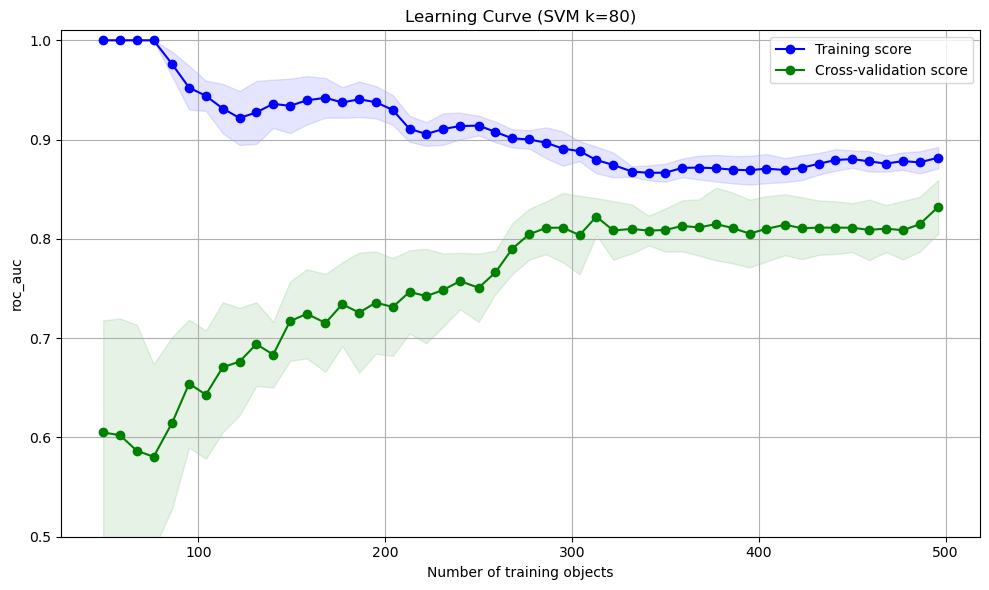

Number of Features Selected after RFECV: 40
Mean ROC AUC: 0.822172240476067


In [84]:
# K = 80
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=80)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=80')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

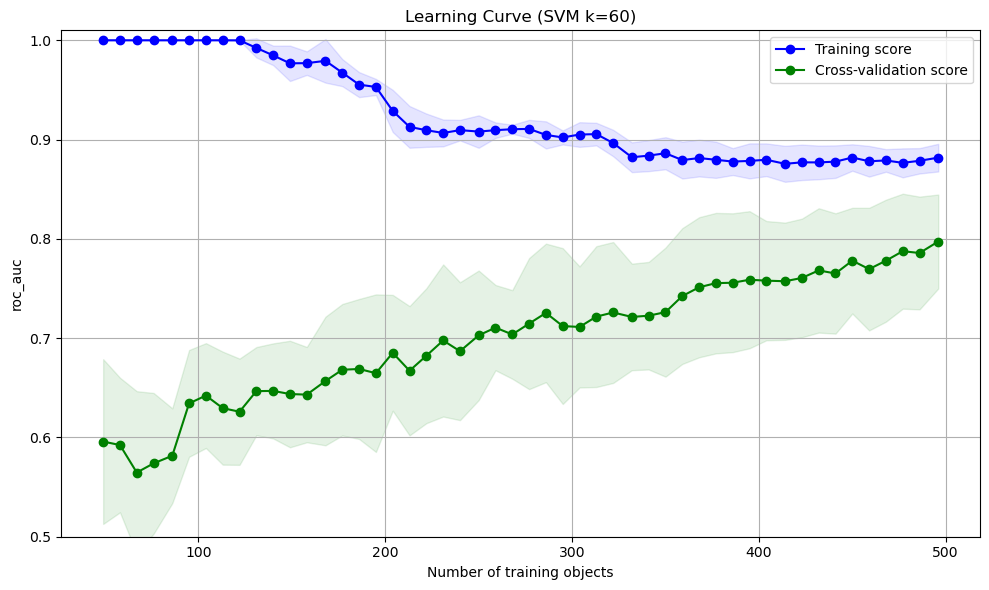

Number of Features Selected after RFECV: 55
Mean ROC AUC: 0.7969804514921591


In [85]:
# K = 60
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=60')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

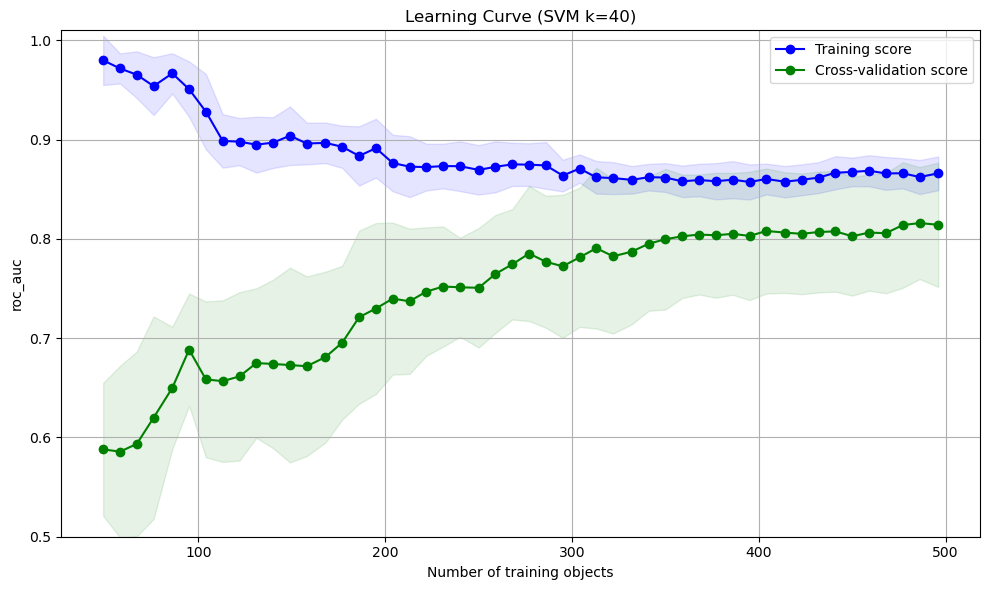

Number of Features Selected after RFECV: 30
Mean ROC AUC: 0.8194049905928832


In [86]:
# K = 40 
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=40)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=40')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

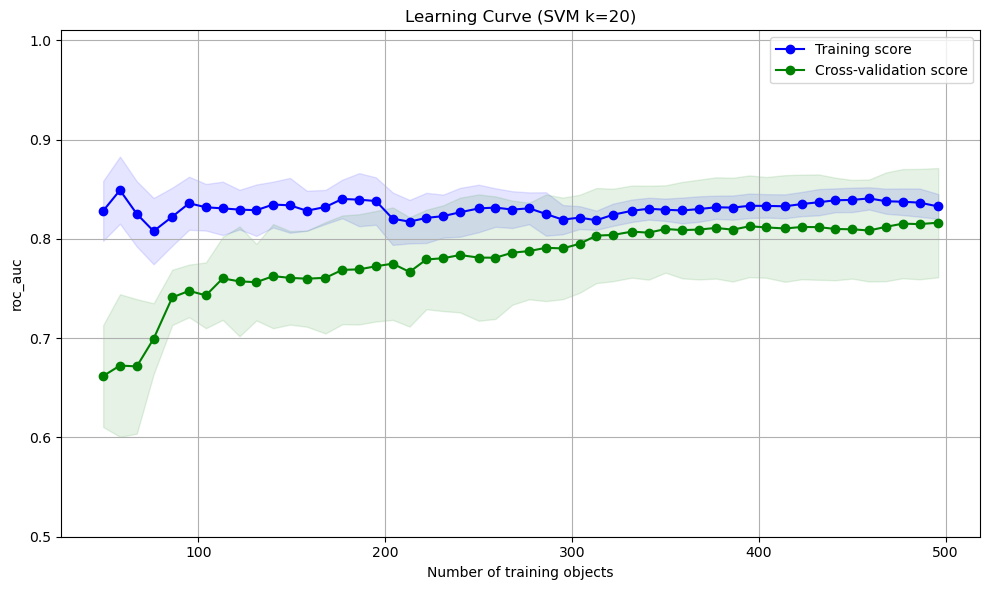

Number of Features Selected after RFECV: 10
Mean ROC AUC: 0.8187417950410525


In [87]:
# K = 20
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for fe5ature selection
selector = SelectKBest(mutual_info_classif, k=20)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=20')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

Since K=20 gave the best learning curve, also a learning curve for K=25 and K=15 are made. 

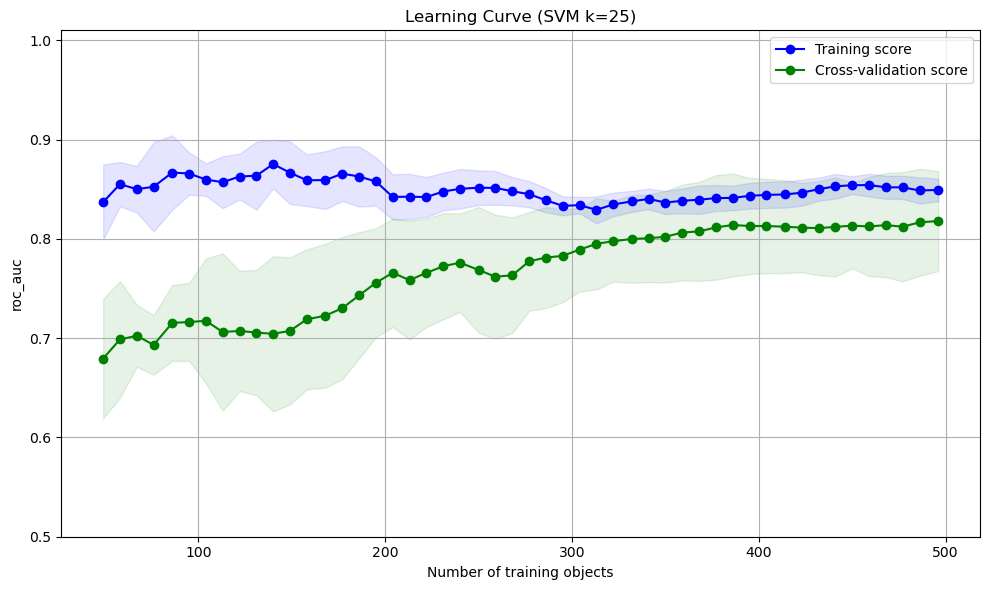

Number of Features Selected after RFECV: 15
Mean ROC AUC: 0.8239417920742879


In [88]:
#K=25
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=25)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=25')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

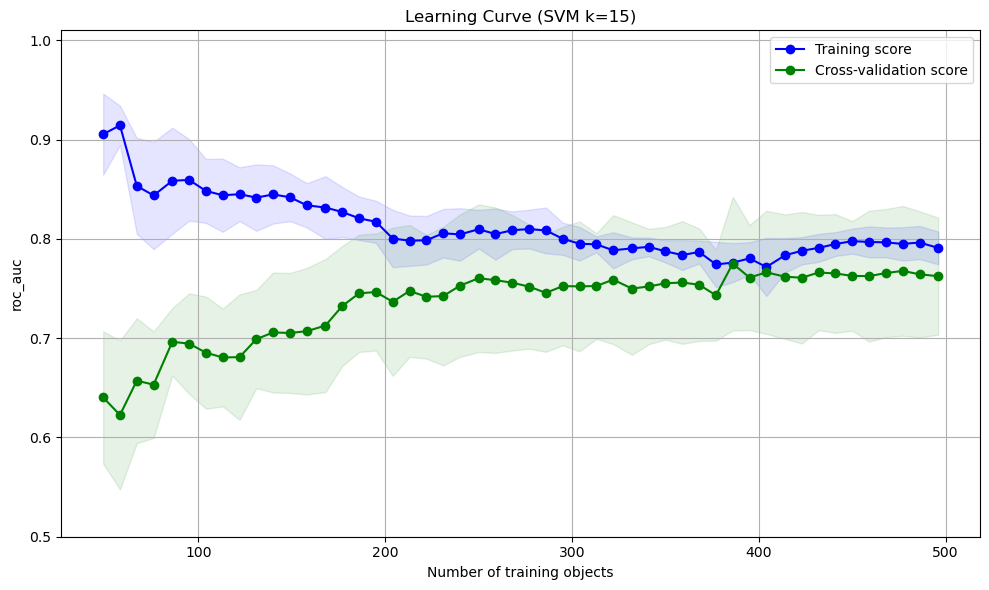

Number of Features Selected after RFECV: 10
Mean ROC AUC: 0.7641716174554553


In [89]:
# K = 15
# ====== PRE-FEATURE SELECTION ======
# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=15)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=15')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Mean ROC AUC:", scores.mean())

Linear kernel tuned

In [90]:
# once specify the characteristics of the SVM for SVC feature selection
svm_feature = SVC(kernel="linear", random_state=42, class_weight='balanced')

Best estimator: Pipeline(steps=[('transformer', PowerTransformer()),
                ('select_k_best',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x0000024F1240B240>)),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                       estimator=SVC(class_weight='balanced', kernel='linear',
                                     random_state=42),
                       scoring='roc_auc', step=5)),
                ('classifier',
                 SVC(C=0.001, class_weight='balanced', kernel='linear',
                     max_iter=10000, random_state=42, tol=1e-06))])
Best Score: 0.6979534267369789
Best parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': 10000, 'classifier__C': 0.001}
Mean ROC AUC: 0.6522116860866147


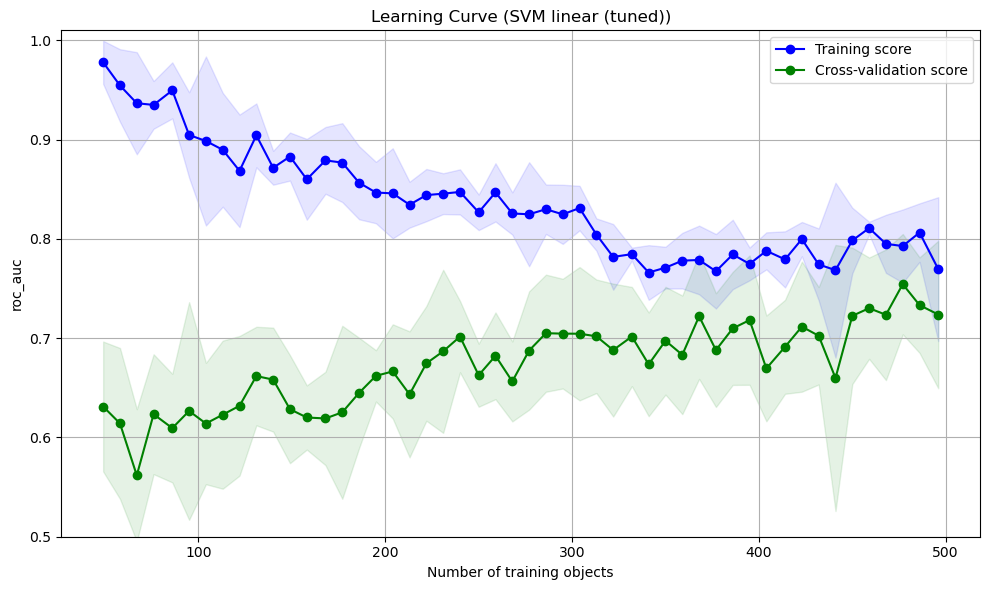

In [91]:
# tuned linear kernel
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('select_k_best', SelectKBest(mutual_info_classif, k=25)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))
])

parameters = {
    'classifier__C':            [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__tol':          [1e-4, 1e-5, 1e-6],             
    'classifier__max_iter':     [1000, 10000, -1]    
}

# ====== EVALUATION  ======
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=parameters,
    n_iter=20,
    n_jobs=-1,
    cv=cv,
    scoring='roc_auc'  ,
    random_state=42
) 

random_search.fit(X_train, y_train)

print("Best estimator:", random_search.best_estimator_ )
print("Best Score:", random_search.best_score_)
print("Best parameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

plot_learning_curve(X_train, y_train, classifier=random_search.best_estimator_, scoring='roc_auc', clf_type='SVM linear (tuned)')

Since the data did not seem to be linear seperable a polynomial and RBF kernel are also trained

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('transformer', PowerTransformer()),
                ('select_k_best',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x0000024F1240B240>)),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                       estimator=SVC(class_weight='balanced', kernel='linear',
                                     random_state=42),
                       scoring='roc_auc', step=5)),
                ('classifier',
                 SVC(C=0.01, class_weight='balanced', gamma=1e-06,
                     kernel='poly', max_iter=10000, random_state=42,
                     tol=0.0001))])
Best Score: 0.6830827035138857
Best parameters: {'classifier__tol': 0.0001, 'classifier__max_iter': 10000, 'classifier__gamma': 1e-06, 'classifier__C': 0.01}
Mean ROC AUC: 0.6764369309065197


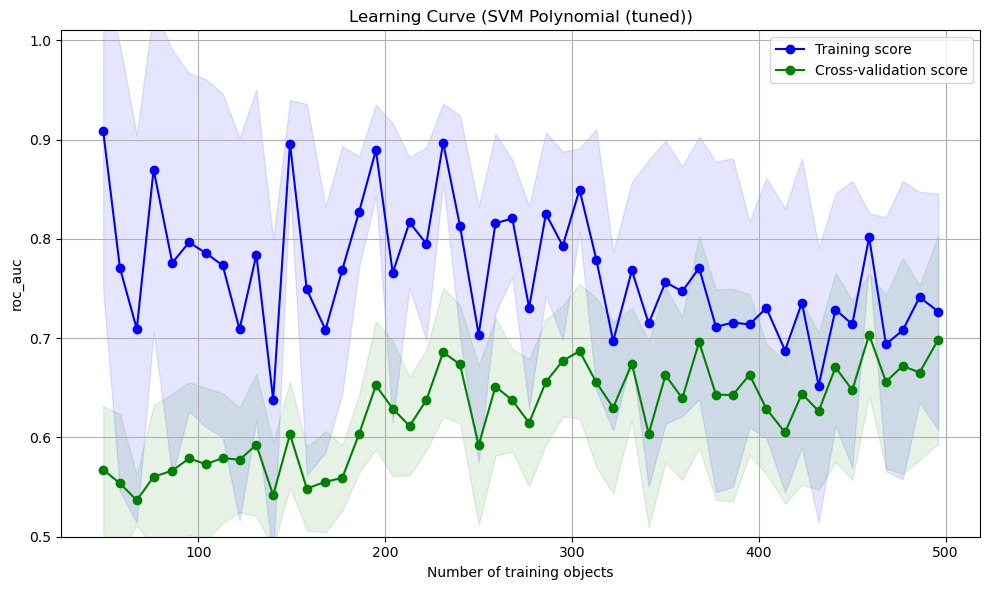

In [92]:
# tuned polynomial kernel
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('select_k_best', SelectKBest(mutual_info_classif, k=25)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='poly', random_state=42, class_weight='balanced'))
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1],
    'classifier__gamma': [1e-6, 1e-5, 1e-4],
    'classifier__tol': [1e-4, 1e-5, 1e-6],
    'classifier__max_iter': [1000, 10000, -1]
}

# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=42
)

# ====== 4. TRAINING ======
random_search.fit(X_train, y_train)

# ====== 5. RESULTATEN ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best Score:", random_search.best_score_)
print("Best parameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_train,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM Polynomial (tuned)'
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('transformer', PowerTransformer()),
                ('select_k_best',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x0000024F1240B240>)),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                       estimator=SVC(class_weight='balanced', kernel='linear',
                                     random_state=42),
                       scoring='roc_auc', step=5)),
                ('classifier',
                 SVC(C=5, class_weight='balanced', gamma=0.009, random_state=42,
                     tol=0.0005))])
Best Score: 0.6869592144006764
Best parameters: {'classifier__tol': 0.0005, 'classifier__max_iter': -1, 'classifier__gamma': 0.009, 'classifier__C': 5}
Mean ROC AUC: 0.6847377441709253


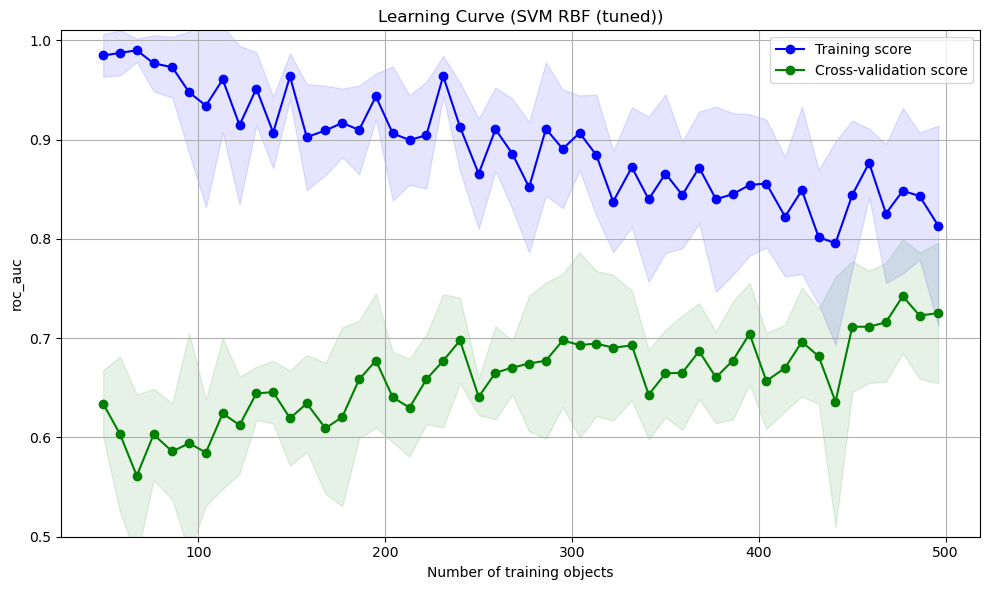

In [93]:
# tuned RBF kernel
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('select_k_best', SelectKBest(mutual_info_classif, k=25)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='rbf', random_state=42, class_weight='balanced'))
])

param_grid = {
    'classifier__C': [4, 4.5, 5],
    'classifier__gamma': [0.0085, 0.009, 0.0095],
    'classifier__tol': [3e-4, 5e-4, 7e-4],
    'classifier__max_iter': [80000, 10000, -1]
}

# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=42
)

# ====== 4. TRAINING ======
random_search.fit(X_train, y_train)

# ====== 5. RESULTATEN ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best Score:", random_search.best_score_)
print("Best parameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_train,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF (tuned)'
)

The linear model had the best performance, therefore this model was chosen for final evaluation

Best Parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': -1, 'classifier__C': 0.01}
Best Score: 0.7295804463551437
Accuracy:  0.735
Precision: 0.347
Recall:    0.586
F1 Score:  0.436
AUC Score: 0.700
Best Parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': 10000, 'classifier__C': 0.001}
Best Score: 0.6941231219252758
Accuracy:  0.801
Precision: 0.459
Recall:    0.567
F1 Score:  0.507
AUC Score: 0.758
Best Parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': 10000, 'classifier__C': 0.001}
Best Score: 0.7864213535434118
Accuracy:  0.782
Precision: 0.415
Recall:    0.586
F1 Score:  0.486
AUC Score: 0.726
Best Parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': -1, 'classifier__C': 0.001}
Best Score: 0.7637647919159686
Accuracy:  0.788
Precision: 0.432
Recall:    0.655
F1 Score:  0.521
AUC Score: 0.757
Best Parameters: {'classifier__tol': 1e-06, 'classifier__max_iter': 10000, 'classifier__C': 0.001}
Best Score: 0.7769811195319771
Accuracy:  0.806


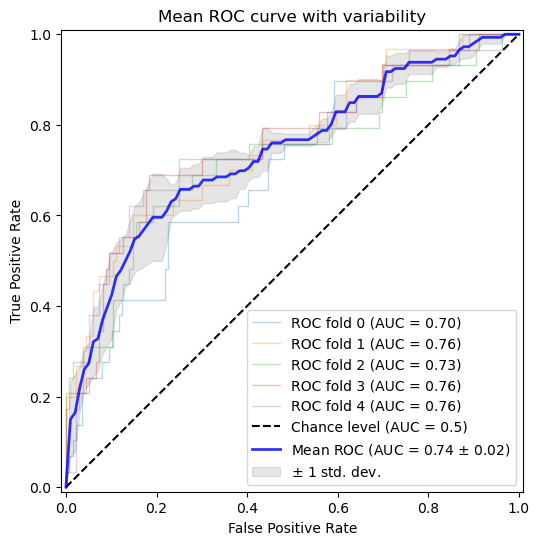

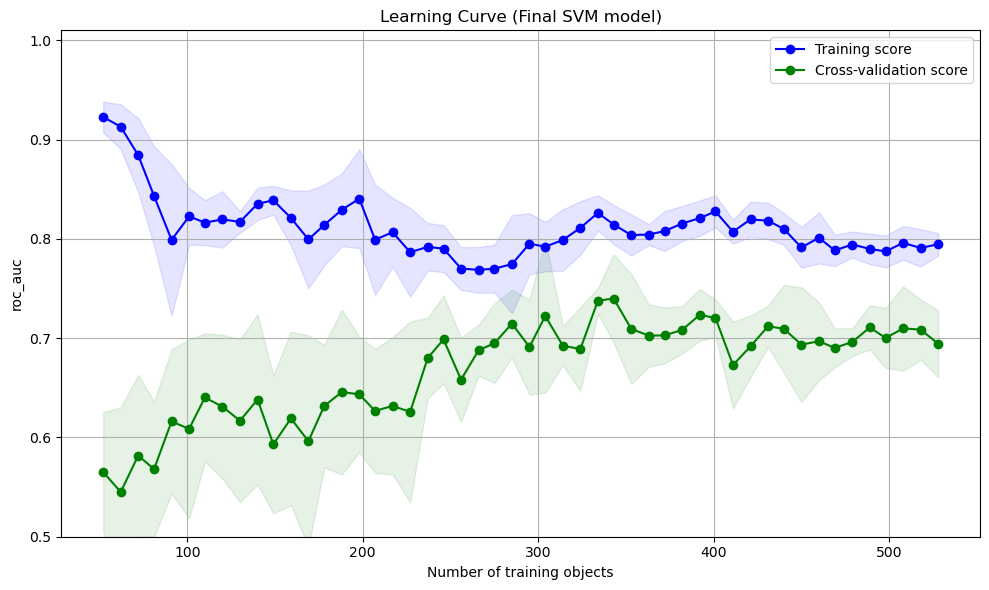

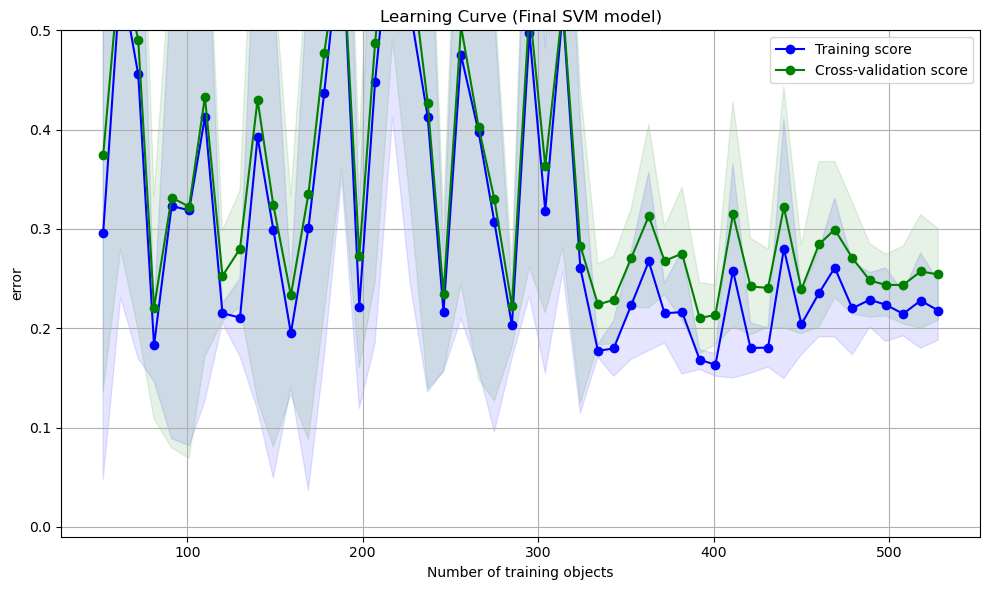

In [94]:
# ROC AUC curve with outside cross validation
def optimize_svm(X_train, y_train):
    # ====== PIPELINE  ======
    pipeline = Pipeline([
        ('transformer', PowerTransformer(method='yeo-johnson')),
        ('select_k_best', SelectKBest(mutual_info_classif, k=25)),
        ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
        ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced', probability=True))
    ])

    parameters = {
        'classifier__C':            [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__tol':          [1e-4, 1e-5, 1e-6],             
        'classifier__max_iter':     [1000, 10000, -1]    
    }

    # ====== EVALUATION  ======
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=parameters,
        n_iter=20,
        n_jobs=-1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        random_state=42  
    ) 

    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

# Perform hyperparameter optimization and plot the ROC curves and learning curves
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train_final, y_train_final, best_classifier = plot_roc_cv(X, y, optimize_svm, n_splits=5)
plot_learning_curve(X_train_final, y_train_final, best_classifier, scoring='roc_auc', clf_type='Final SVM model')
plot_learning_curve(X_train_final, y_train_final, best_classifier, scoring='error', clf_type='Final SVM model')

### Tuning steps for SVM

Select correct features

In [95]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=25)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# ====== FEATURE SELECTION ======
rfecv = RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

Linear kernel

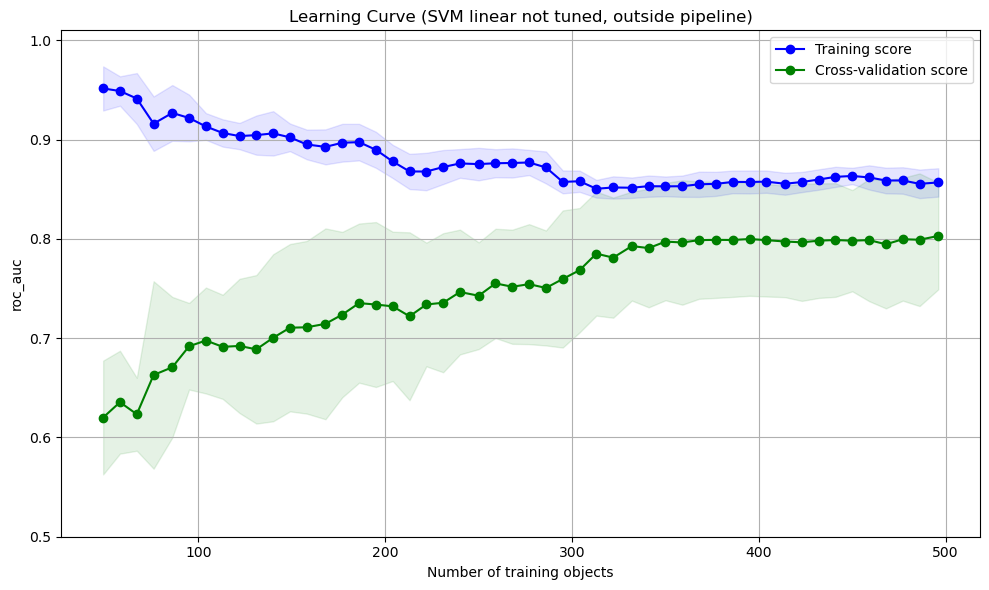

Mean ROC AUC: 0.7919147005668994


In [96]:
# Not tuned linear kernel outside the pipeline
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))
])


# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM linear not tuned, outside pipeline')
print("Mean ROC AUC:", scores.mean())

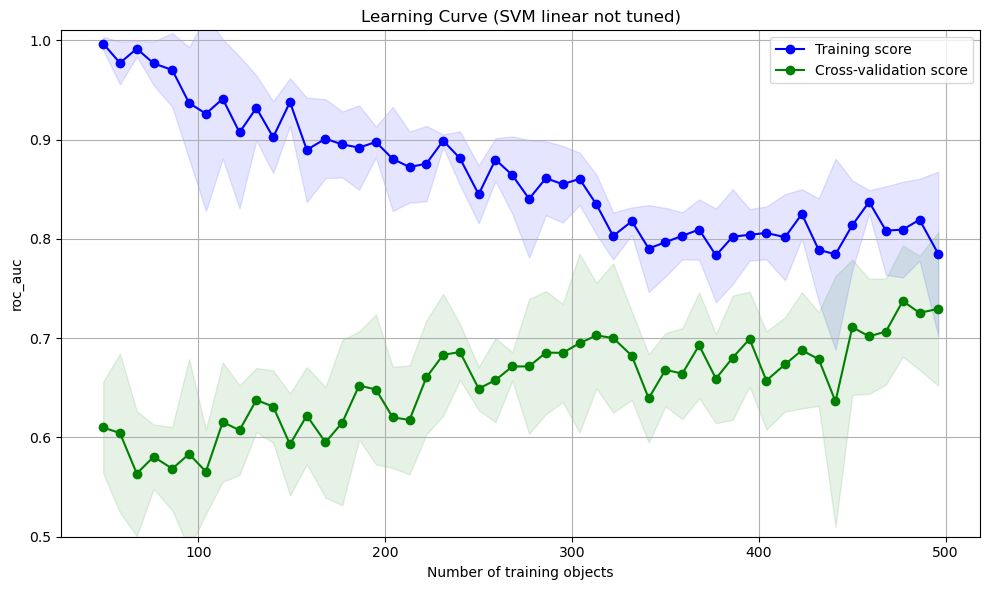

Mean ROC AUC: 0.6733024542561951


In [97]:
# Not tuned linear kernel inside the pipeline
# ====== PIPELINE  ======
pipeline = Pipeline([
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('select_k_best', SelectKBest(mutual_info_classif, k=25)),
    ('rfecv', RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')),
    ('classifier', SVC(kernel='linear', random_state=42, class_weight='balanced'))
])


# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_train, y_train)

plot_learning_curve(X_train, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM linear not tuned')
print("Mean ROC AUC:", scores.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('classifier',
                 SVC(C=0.001, class_weight='balanced', kernel='linear',
                     max_iter=10000, random_state=42, tol=1e-05))])
Best ROC AUC-score: 0.8126871225100807
Best hyperparameters: {'classifier__tol': 1e-05, 'classifier__max_iter': 10000, 'classifier__C': 0.001}
Mean ROC AUC: 0.7647419594492695


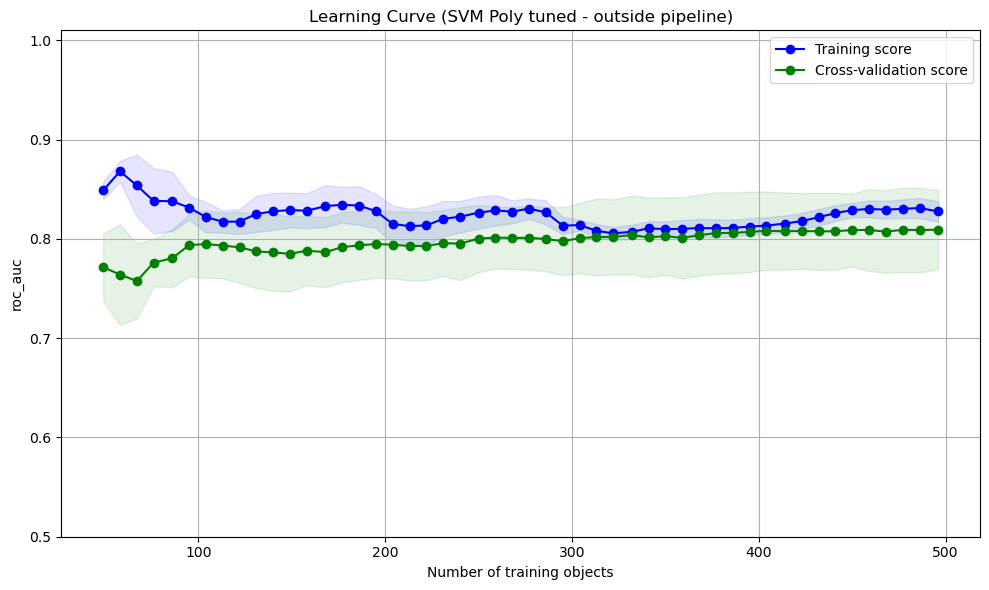

In [98]:
# Tuned linear kernel outside the pipeline
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(
    kernel="linear",  
    random_state=42,
    class_weight='balanced'
)

# ====== PIPELINE ======
pipeline = Pipeline([
    ('classifier', svm)
])

# ====== HYPERPARAMETER ======
parameters = {
    'classifier__C':            [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__tol':          [1e-4, 1e-5, 1e-6],             
    'classifier__max_iter':     [1000, 10000, -1]    
}


# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameters,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== 4. TRAINING ======
random_search.fit(X_selected, y_train)

# ====== 5. RESULTATEN ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best ROC AUC-score:", random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM Poly tuned - outside pipeline'
)

Polynomial kernel



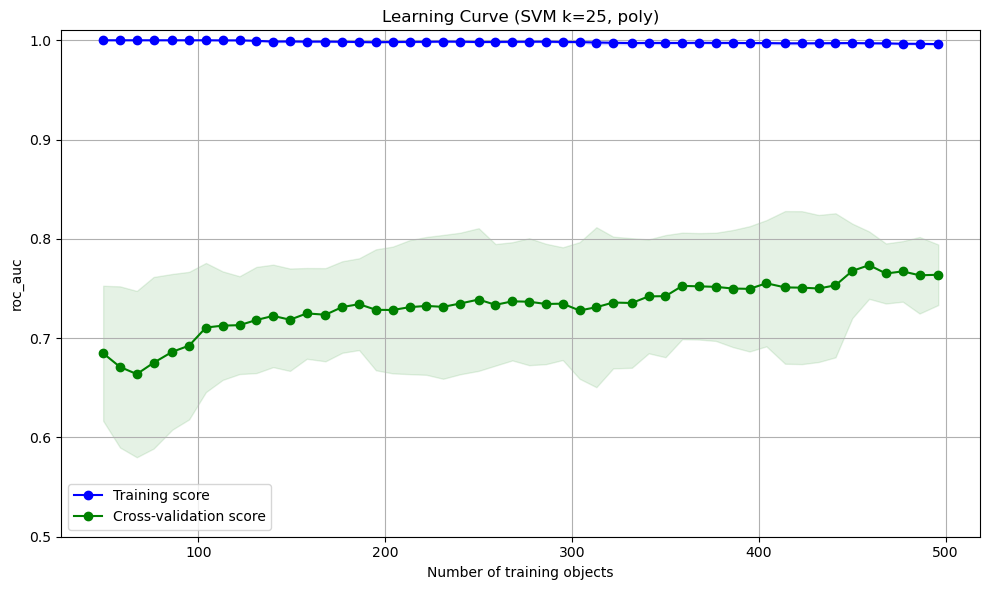

Mean ROC AUC: 0.7614795256143058


In [99]:
# not tuned polynomial outside the pipeline
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="poly", random_state=42, class_weight='balanced')

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM k=25, poly')
print("Mean ROC AUC:", scores.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('classifier',
                 SVC(C=0.1, class_weight='balanced', gamma=1e-06, kernel='poly',
                     max_iter=1000, random_state=42, tol=0.0001))])
Best ROC AUC-score: 0.7953219681517797
Best hyperparameters: {'classifier__tol': 0.0001, 'classifier__max_iter': 1000, 'classifier__gamma': 1e-06, 'classifier__C': 0.1}
Mean ROC AUC: 0.7919563125338397


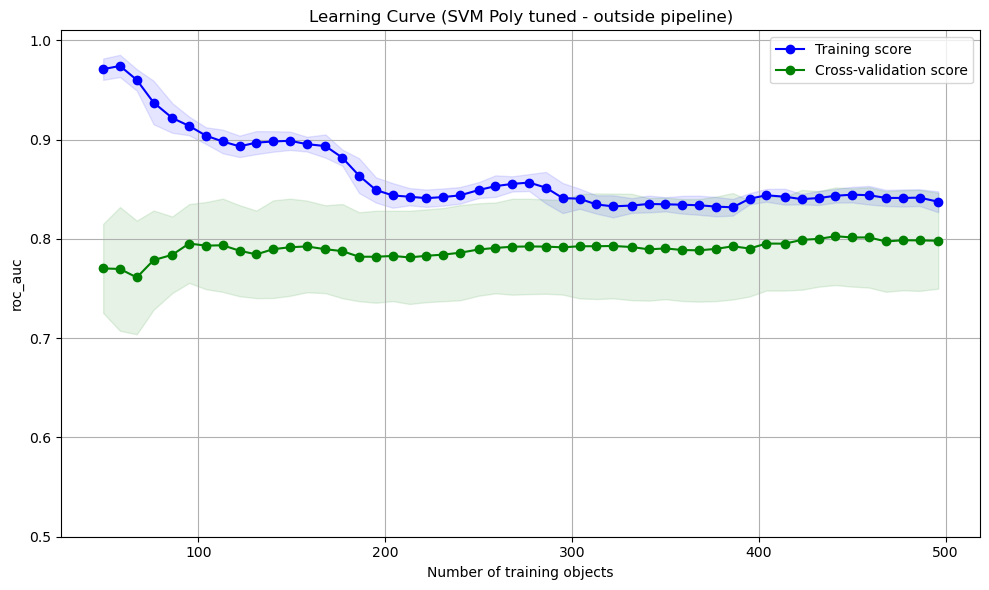

In [100]:
# tuned poly outside pipeline
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(
    kernel="poly",  
    random_state=42,
    class_weight='balanced'
)

# ====== PIPELINE ======
pipeline = Pipeline([
    ('classifier', svm)
])

# ====== HYPERPARAMETER ======
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1],
    'classifier__gamma': [1e-6, 1e-5, 1e-4],
    'classifier__tol': [1e-4, 1e-5, 1e-6],
    'classifier__max_iter': [1000, 10000, -1]
}


# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== 4. TRAINING ======
random_search.fit(X_selected, y_train)

# ====== 5. RESULTATEN ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best ROC AUC-score:", random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())


# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM Poly tuned - outside pipeline'
)

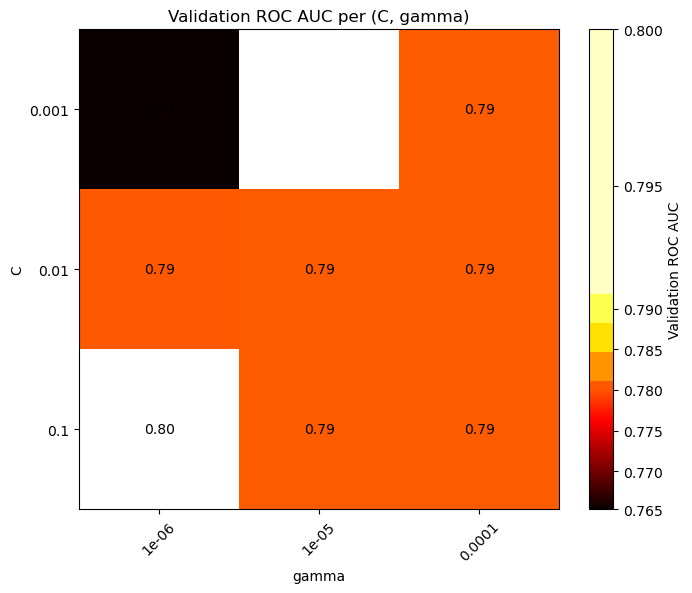

In [101]:
# code for hyperparameter tuning of polynomial
# ===== MidpointNormalize class =====
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        return np.ma.masked_array(np.interp(value, [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]))

# ===== Extract C and gamma ranges from param_grid =====
C_range = param_grid['classifier__C']
gamma_range = param_grid['classifier__gamma']

scores = np.full((len(C_range), len(gamma_range)), np.nan)  # initialize with NaN

for idx, result in enumerate(random_search.cv_results_['params']):
    c_val = result['classifier__C']
    gamma_val = result['classifier__gamma']
    if c_val in C_range and gamma_val in gamma_range:
        c_idx = C_range.index(c_val)
        gamma_idx = gamma_range.index(gamma_val)
        scores[c_idx, gamma_idx] = random_search.cv_results_['mean_test_score'][idx]

# ===== Plot heatmap =====
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)

plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(
        vmin=np.nanmin(scores),
        midpoint=np.nanmedian(scores),
        vmax=np.nanmax(scores)
    )
)

plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar(label='Validation ROC AUC')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation ROC AUC per (C, gamma)")

# ===== ROC =====
for i in range(len(C_range)):
    for j in range(len(gamma_range)):
        if not np.isnan(scores[i, j]):
            plt.text(j, i, f"{scores[i, j]:.2f}", ha='center', va='center', color='black')

plt.show()

RBF kernel

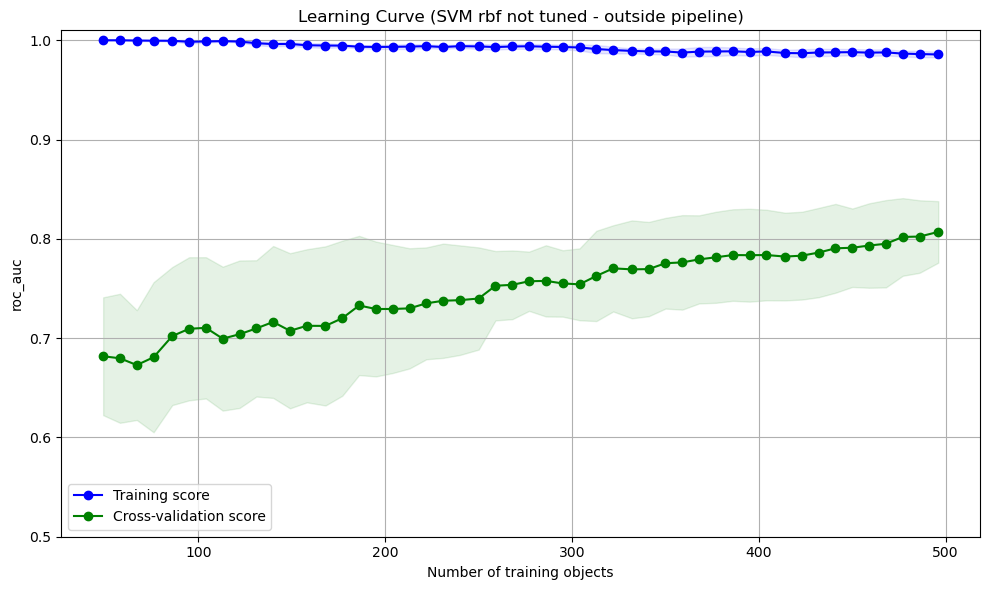

Mean ROC AUC: 0.7932404735945571


In [102]:
# not tuned RBF kernel outside the pipeline
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="rbf", random_state=42, class_weight='balanced')

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

plot_learning_curve(X_selected, y_train, classifier=pipeline, scoring='roc_auc', clf_type='SVM rbf not tuned - outside pipeline')
print("Mean ROC AUC:", scores.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('classifier',
                 SVC(C=0.1, class_weight='balanced', gamma=0.01,
                     random_state=42))])
Best ROC AUC-score: 0.8162531738202784
Best hyperparameters: {'classifier__tol': 0.001, 'classifier__max_iter': -1, 'classifier__gamma': 0.01, 'classifier__C': 0.1}
Mean ROC AUC: 0.791366683478334


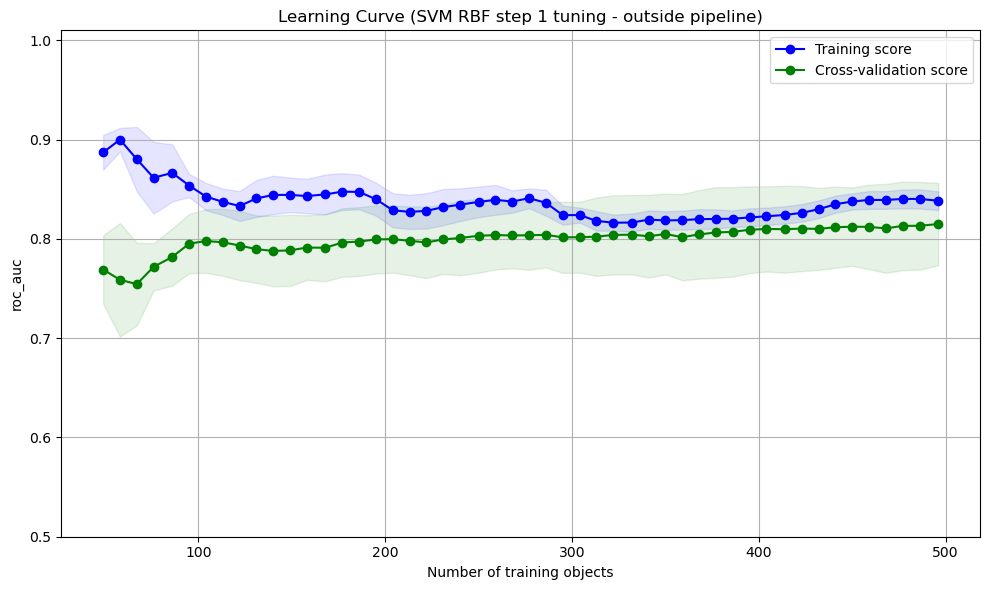

In [103]:
# step 1 of tuned RBF kernel outside the pipeline
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(
    kernel="rbf",
    random_state=42,
    class_weight='balanced'
)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('classifier', svm)
])

# ====== HYPERPARAMETER ======
param_grid = {
    'classifier__C': [0.1, 1, 10, 100, 1000],
    'classifier__gamma': [1e-4, 1e-3, 1e-2, 0.1, 1],
    'classifier__tol': [1e-3, 1e-4, 1e-5],
    'classifier__max_iter': [10000, 20000, -1]
}

# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== 4. TRAINING ======
random_search.fit(X_selected, y_train)

# ====== 5. RESULTATEN ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best ROC AUC-score:", random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF step 1 tuning - outside pipeline'
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator:
 Pipeline(steps=[('classifier',
                 SVC(C=100, class_weight='balanced', gamma=1e-05, max_iter=1000,
                     random_state=42, tol=0.0001))])
Best ROC AUC-score: 0.8146579196550642
Best hyperparameters: {'classifier__tol': 0.0001, 'classifier__max_iter': 1000, 'classifier__gamma': 1e-05, 'classifier__C': 100}
Mean ROC AUC: 0.7990311720451642


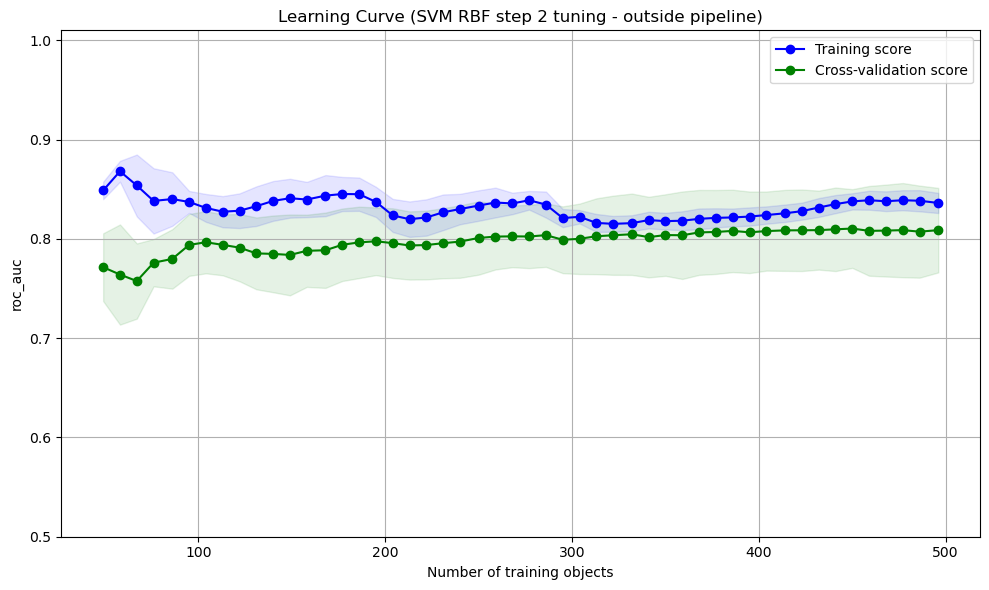

In [104]:
# step 2 of tuned RBF kernel outside the pipeline
# ====== SVM & Pipeline Setup ======
pipeline = Pipeline([
    ('classifier', SVC(kernel='rbf', class_weight='balanced', random_state=42))
])

# ====== Hyperparameter ======
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__gamma': [1e-5, 1e-4, 1e-3, 1e-2, 0.1],
    'classifier__tol': [1e-3, 1e-4, 1e-5],
    'classifier__max_iter': [1000, 10000, -1]
}

# ====== Randomized Search CV ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,            
    scoring='roc_auc',
    cv=cv,                 
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== Fit model op trainingsdata ======
random_search.fit(X_selected, y_train)

# ====== Resultaten tonen ======
print("Best estimator:\n", random_search.best_estimator_)
print("Best ROC AUC-score:", random_search.best_score_)
print("Best hyperparameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())

# ====== LEARNING CURVE PLOT ======
plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF step 2 tuning - outside pipeline'
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
New Best estimator:
 Pipeline(steps=[('classifier',
                 SVC(C=4, class_weight='balanced', gamma=0.009, max_iter=80000,
                     random_state=42, tol=0.0005))])
New best ROC AUC-score: 0.7982866933181039
New best hyperparameters: {'classifier__tol': 0.0005, 'classifier__max_iter': 80000, 'classifier__gamma': 0.009, 'classifier__C': 4}
Mean ROC AUC: 0.7972445491877245


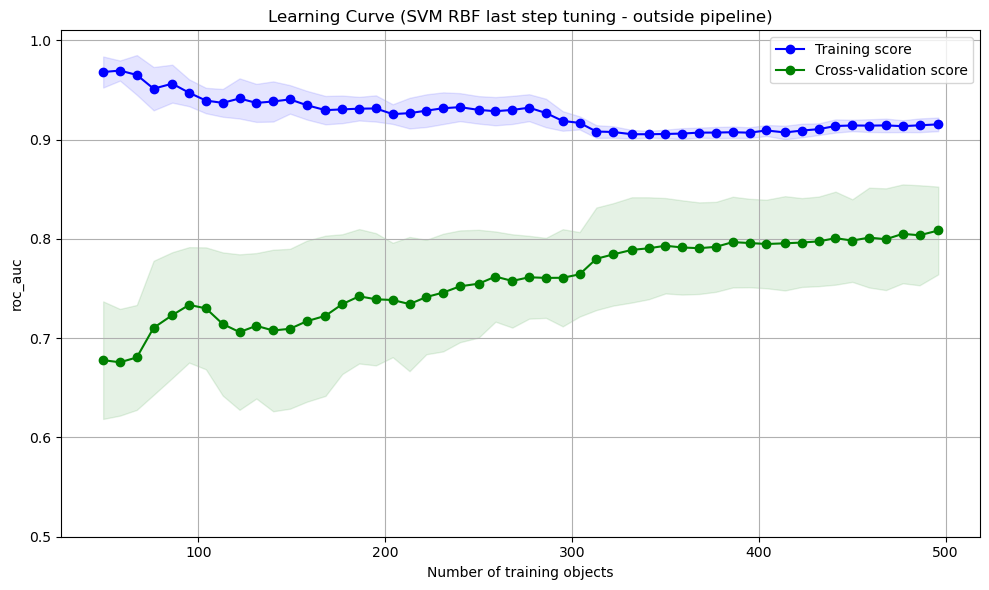

In [105]:
# last step of tuned RBF kernel outside the pipeline
# ====== SVM & Pipeline Setup ======
pipeline = Pipeline([
    ('classifier', SVC(kernel='rbf', class_weight='balanced', random_state=42))
])

# ====== Nog fijnmaziger Hyperparameter Ruimte ======
param_grid = {
    'classifier__C': [4, 4.5, 5],
    'classifier__gamma': [0.0085, 0.009, 0.0095],
    'classifier__tol': [3e-4, 5e-4, 7e-4],
    'classifier__max_iter': [80000, 10000, -1]
}

# ====== Randomized Search CV ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=42
)

# ====== Fit model op trainingsdata ======
random_search.fit(X_selected, y_train)

# ====== Resultaten tonen ======
print("New Best estimator:\n", random_search.best_estimator_)
print("New best ROC AUC-score:", random_search.best_score_)
print("New best hyperparameters:", random_search.best_params_)
print("Mean ROC AUC:", random_search.cv_results_['mean_test_score'].mean())


# ====== 6. LEARNING CURVE PLOT ======
plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF last step tuning - outside pipeline'
)

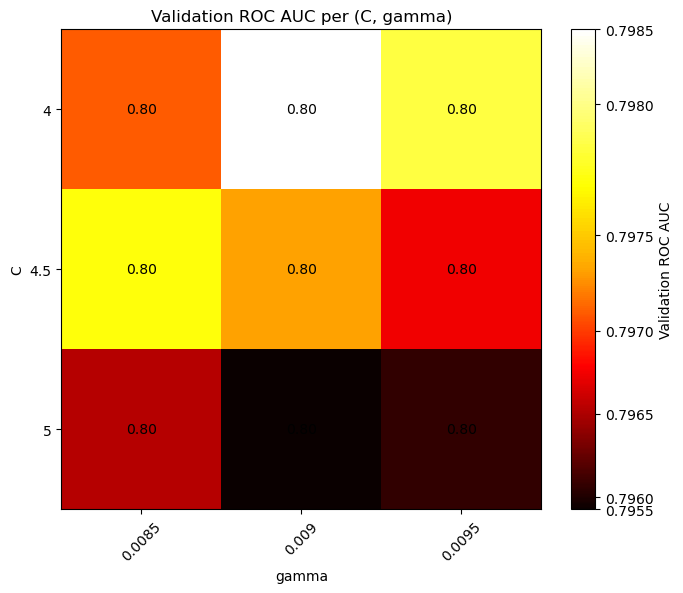

In [106]:
# code for hyperparameter tuning of rbf
# ===== MidpointNormalize class =====
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        return np.ma.masked_array(np.interp(value, [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]))

# ===== Extract C and gamma ranges from param_grid =====
C_range = param_grid['classifier__C']
gamma_range = param_grid['classifier__gamma']

scores = np.full((len(C_range), len(gamma_range)), np.nan)  # initialize with NaN

for idx, result in enumerate(random_search.cv_results_['params']):
    c_val = result['classifier__C']
    gamma_val = result['classifier__gamma']
    if c_val in C_range and gamma_val in gamma_range:
        c_idx = C_range.index(c_val)
        gamma_idx = gamma_range.index(gamma_val)
        scores[c_idx, gamma_idx] = random_search.cv_results_['mean_test_score'][idx]

# ===== Plot heatmap =====
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)

plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(
        vmin=np.nanmin(scores),
        midpoint=np.nanmedian(scores),
        vmax=np.nanmax(scores)
    )
)

plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar(label='Validation ROC AUC')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation ROC AUC per (C, gamma)")

# ===== ROC =====
for i in range(len(C_range)):
    for j in range(len(gamma_range)):
        if not np.isnan(scores[i, j]):
            plt.text(j, i, f"{scores[i, j]:.2f}", ha='center', va='center', color='black')

plt.show()

# KNN

In [10]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)
print(X_test.shape)
print(X_train.shape)

cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

(207, 9000)
(620, 9000)


With this code, a learning curve for robust and powertransform was made to make a choise between the scaling/transforming method

ROC AUC scores per fold: [0.88346702 0.74532086 0.73284314 0.67736185 0.72515025]
Gemiddelde ROC AUC: 0.7528286248303381


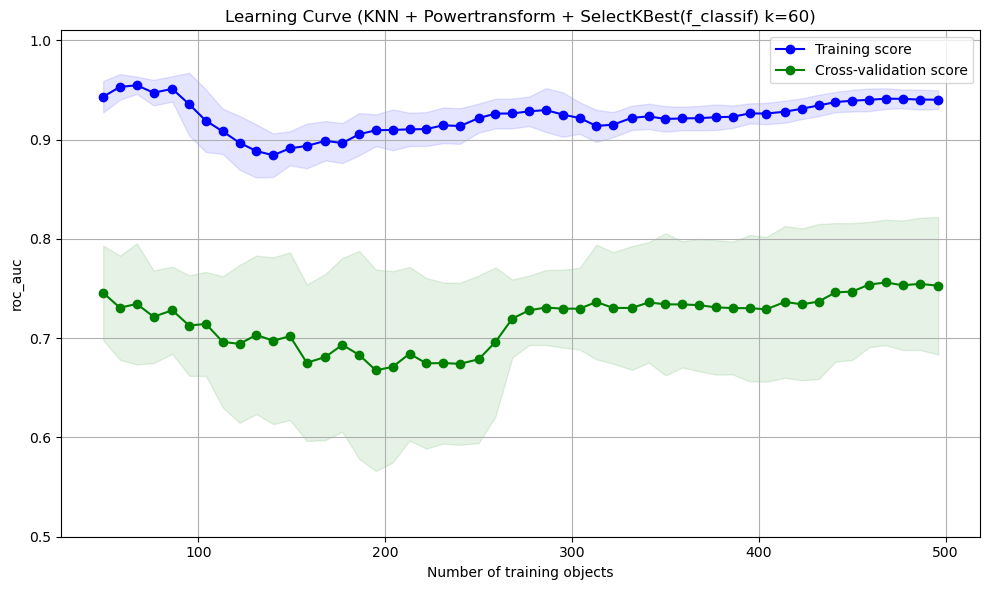

In [102]:
#choose between Robustscaling and powertransform, met f_classif, k=60
#Powertransform
powertransform = PowerTransformer(method='yeo-johnson')
X_train_powertransform = powertransform.fit_transform(X_train)
X_test_powertransform = powertransform.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_powertransform, y_train)
X_test_reduced = selector.transform(X_test_powertransform)

knn = Pipeline([
    ('classifier', KNeighborsClassifier()),
])

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

knn.fit(X_train_reduced, y_train)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(f_classif) k=60')


ROC AUC scores per fold: [0.77384135 0.72370766 0.65953654 0.72259358 0.88927416]
Gemiddelde ROC AUC: 0.7537906601298949


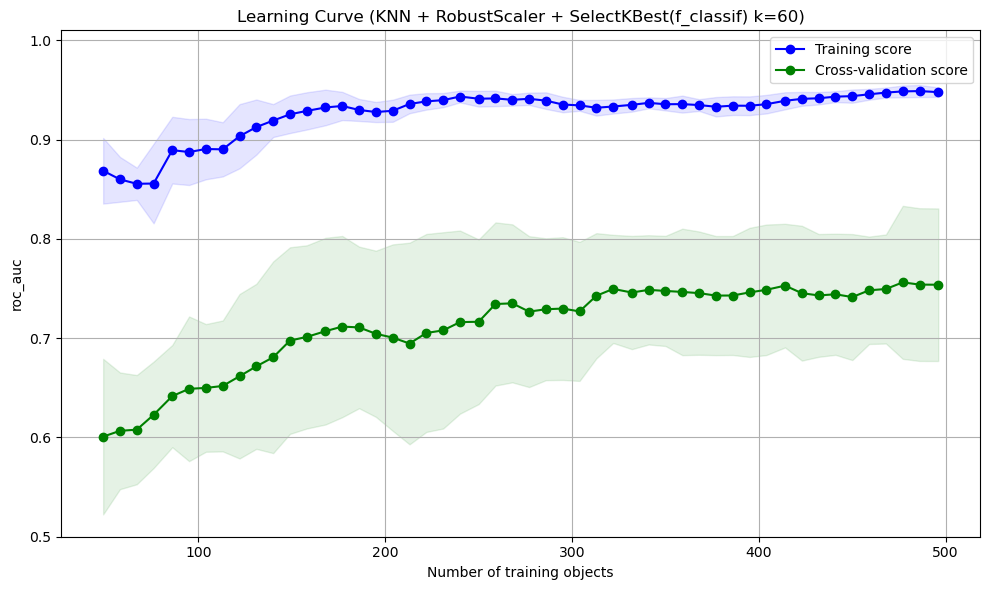

In [103]:
#choose between Robustscaling and powertransform, met mutual_info_classif, k=60
#RobustScaling
robustscaler = RobustScaler()
X_train_robustscaler = robustscaler.fit_transform(X_train)
X_test_robustscaler = robustscaler.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_robustscaler, y_train)
X_test_reduced = selector.transform(X_test_robustscaler)

knn = Pipeline([
    ('classifier', KNeighborsClassifier()),
    
])

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

knn.fit(X_train_reduced, y_train)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + RobustScaler + SelectKBest(f_classif) k=60')

To select the best k for SelectKBest, a learning curve is plotted for K=100, K=80, K=60, K=40 and K=20. This is done with feature selection and scaling outside the pipeline, for computational reasons

ROC AUC scores per fold: [0.84090909 0.78141711 0.7214795  0.69652406 0.79865927]
Gemiddelde ROC AUC: 0.7677978075608001


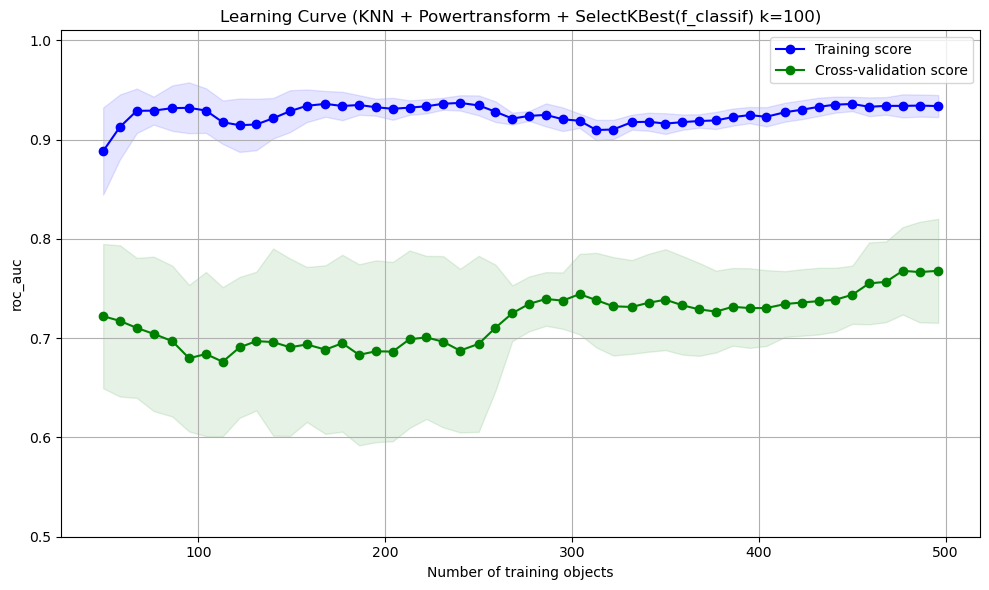

In [ ]:
#Feature selection --> Select the best k=100 
X_train_powertransform = powertransform.fit_transform(X_train)
X_test_powertransform = powertransform.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=100)
X_train_reduced = selector.fit_transform(X_train_powertransform, y_train)
X_test_reduced = selector.transform(X_test_powertransform)

knn = Pipeline([
    ('classifier', KNeighborsClassifier()),
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(f_classif) k=100')

ROC AUC scores per fold: [0.77072193 0.7459893  0.76827094 0.63213012 0.73555247]
Gemiddelde ROC AUC: 0.7305329545763584


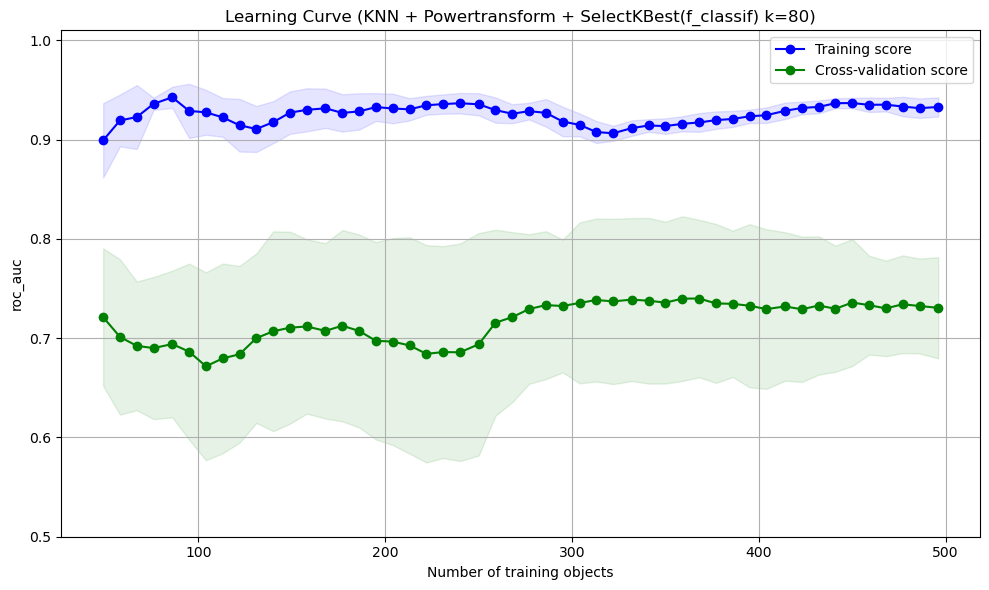

In [105]:
#Feature selection --> Select the best k=80 
#Powertransform
powertransform = PowerTransformer(method='yeo-johnson')
X_train_powertransform = powertransform.fit_transform(X_train)
X_test_powertransform = powertransform.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=80)
X_train_reduced = selector.fit_transform(X_train_powertransform, y_train)
X_test_reduced = selector.transform(X_test_powertransform)

knn = Pipeline([
    ('classifier', KNeighborsClassifier()),
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(f_classif) k=80')

ROC AUC scores per fold: [0.88346702 0.74532086 0.73284314 0.67736185 0.72515025]
Gemiddelde ROC AUC: 0.7528286248303381


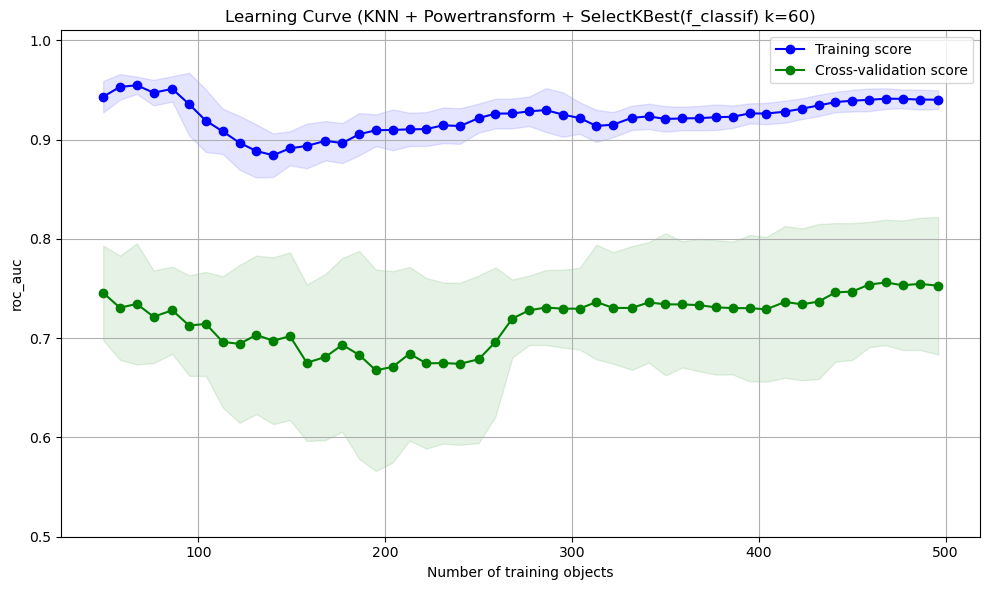

In [107]:
#Feature selection --> Select the best k=60 
#Powertransform
powertransform = PowerTransformer(method='yeo-johnson')
X_train_powertransform = powertransform.fit_transform(X_train)
X_test_powertransform = powertransform.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_powertransform, y_train)
X_test_reduced = selector.transform(X_test_powertransform)

knn = Pipeline([
    ('classifier', KNeighborsClassifier()),
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(f_classif) k=60')

ROC AUC scores per fold: [0.87210339 0.78342246 0.7052139  0.67268271 0.75335183]
Gemiddelde ROC AUC: 0.7573548572120816


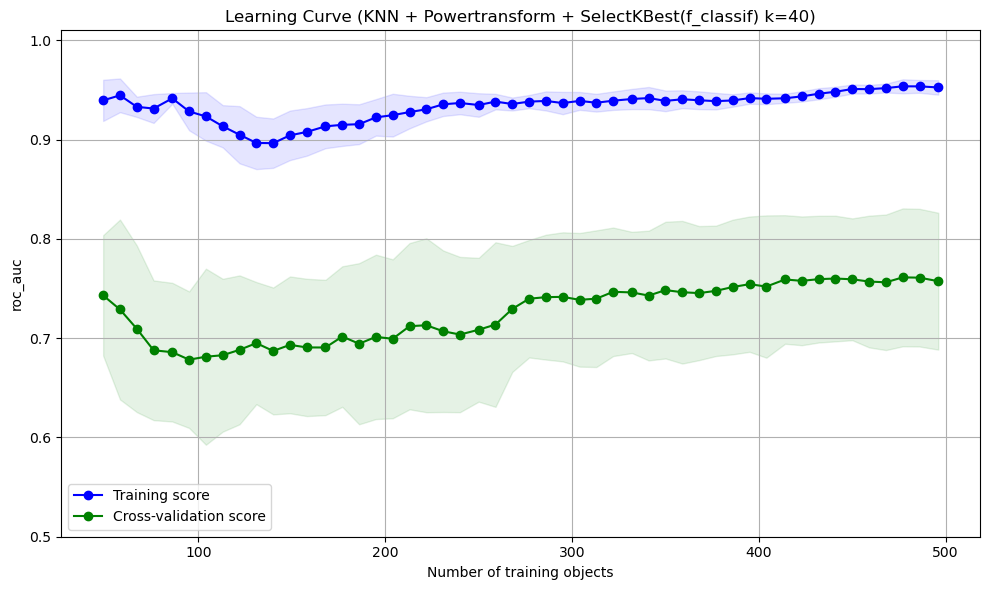

In [108]:
#Feature selection --> Select the best k=40 
#Powertransform
powertransform = PowerTransformer(method='yeo-johnson')
X_train_powertransform = powertransform.fit_transform(X_train)
X_test_powertransform = powertransform.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=40)
X_train_reduced = selector.fit_transform(X_train_powertransform, y_train)
X_test_reduced = selector.transform(X_test_powertransform)

knn = Pipeline([
    ('classifier', KNeighborsClassifier()),
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(f_classif) k=40')

ROC AUC scores per fold: [0.70989305 0.76403743 0.82508913 0.6807041  0.72746186]
Gemiddelde ROC AUC: 0.7414371132389407


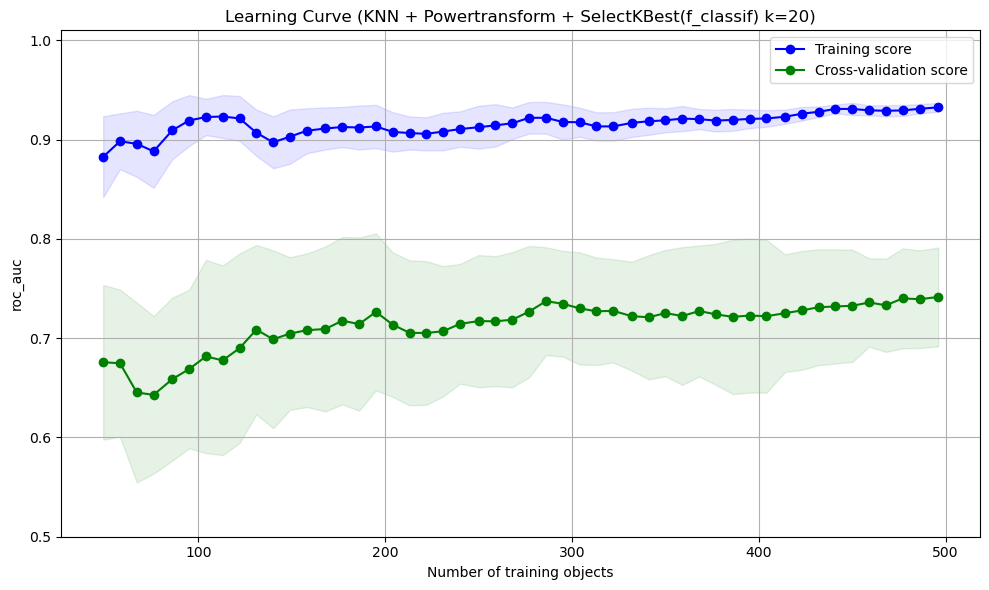

In [109]:
#Feature selection --> Select the best k=20
#Powertransform
powertransform = PowerTransformer(method='yeo-johnson')
X_train_powertransform = powertransform.fit_transform(X_train)
X_test_powertransform = powertransform.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=20)
X_train_reduced = selector.fit_transform(X_train_powertransform, y_train)
X_test_reduced = selector.transform(X_test_powertransform)

knn = Pipeline([
    ('classifier', KNeighborsClassifier()),
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(f_classif) k=20')

We choose K=20, for k=15 and k=25 there are learning curves made tot compare with each other

ROC AUC scores per fold: [0.70454545 0.79991087 0.83333333 0.67580214 0.74225613]
Gemiddelde ROC AUC: 0.7511695852215555


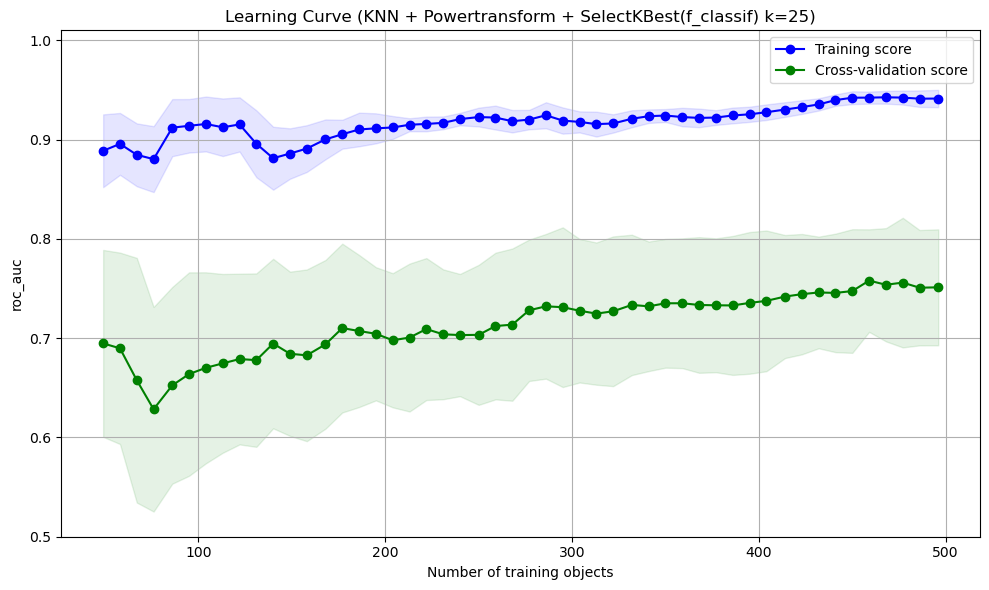

In [110]:
#Feature selection --> Select the best k=25
#Powertransform
powertransform = PowerTransformer(method='yeo-johnson')
X_train_powertransform = powertransform.fit_transform(X_train)
X_test_powertransform = powertransform.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=25)
X_train_reduced = selector.fit_transform(X_train_powertransform, y_train)
X_test_reduced = selector.transform(X_test_powertransform)

knn = Pipeline([
    ('classifier', KNeighborsClassifier()),
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(f_classif) k=25')

ROC AUC scores per fold: [0.70432264 0.69897504 0.77339572 0.69786096 0.7693019 ]
Gemiddelde ROC AUC: 0.7287712525433827


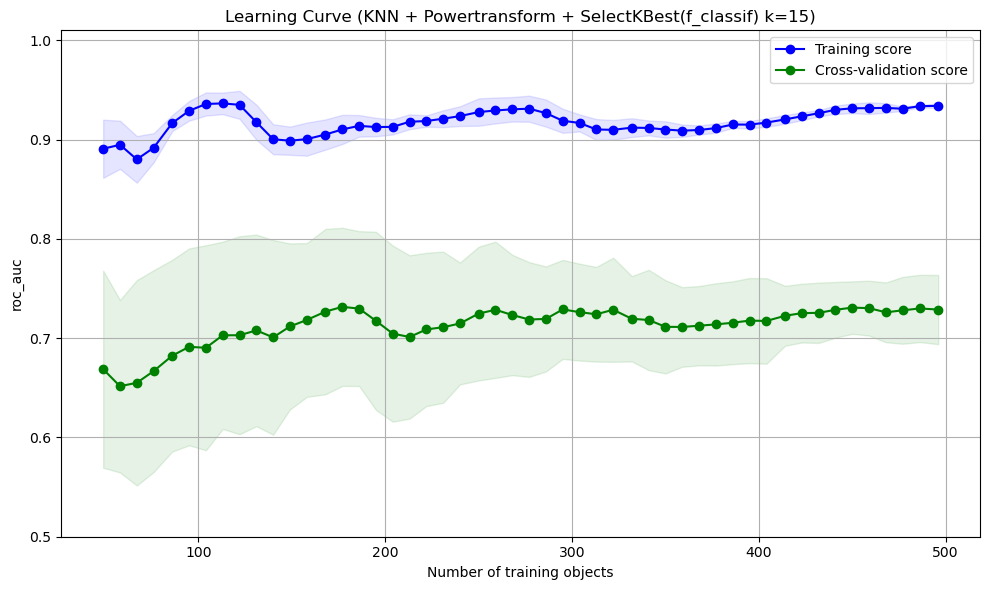

In [111]:
#Feature selection --> Select the best k=15
#Powertransform
powertransform = PowerTransformer(method='yeo-johnson')
X_train_powertransform = powertransform.fit_transform(X_train)
X_test_powertransform = powertransform.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=15)
X_train_reduced = selector.fit_transform(X_train_powertransform, y_train)
X_test_reduced = selector.transform(X_test_powertransform)

knn = Pipeline([
    ('classifier', KNeighborsClassifier()),
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(f_classif) k=15')

ROC AUC scores per fold: [0.70989305 0.76403743 0.82508913 0.6807041  0.72746186]
Gemiddelde ROC AUC: 0.7414371132389407


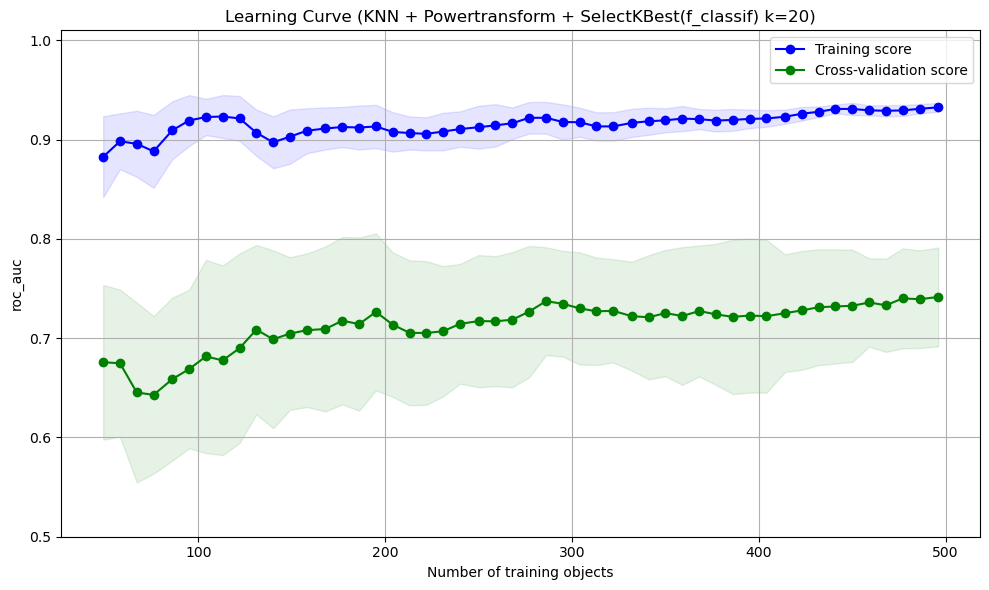

In [112]:
#Feature selection --> Select the best k=20
#Powertransform
powertransform = PowerTransformer(method='yeo-johnson')
X_train_powertransform = powertransform.fit_transform(X_train)
X_test_powertransform = powertransform.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=20)
X_train_reduced = selector.fit_transform(X_train_powertransform, y_train)
X_test_reduced = selector.transform(X_test_powertransform)

knn = Pipeline([
    ('classifier', KNeighborsClassifier()),
])

knn.fit(X_train_reduced, y_train)

scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Gemiddelde ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='roc_auc', clf_type='KNN + Powertransform + SelectKBest(f_classif) k=20')

Hyperparameter tuning with SelectKBest with f_classif instead of mutual_info_classif due to computational reasons. And plotting the learning curve 

Best estimator: Pipeline(steps=[('scaler', PowerTransformer()),
                ('feature_selection', SelectKBest(k=25)),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=25))])
Best ROC_AUC Score: 0.76754328386253
best parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 25, 'classifier__metric': 'euclidean'}


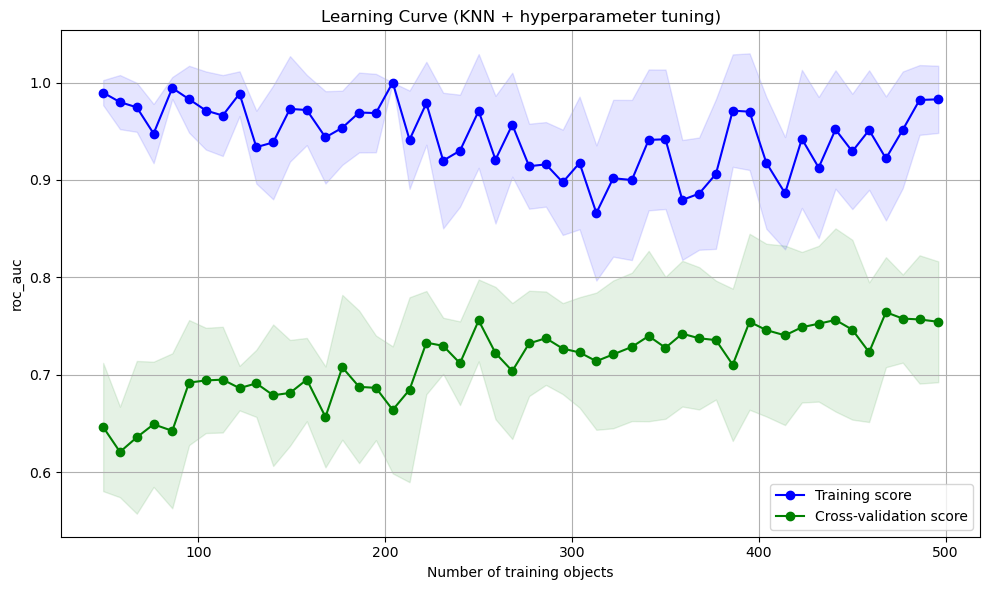

In [ ]:
#Hyperparameter tuning
knn = Pipeline([
    ('scaler', PowerTransformer(method='yeo-johnson')),
    ('feature_selection', SelectKBest(f_classif, k=25)),
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors': [21, 23, 25, 27, 29],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=3,
    n_jobs=-1,
    cv=cv,
    scoring='roc_auc'  
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best ROC_AUC Score:", model.best_score_)
print("best parameters:", model.best_params_)

plot_learning_curve(X_train, y_train, classifier=model, scoring='roc_auc', clf_type='KNN + hyperparameter tuning')

Plotting the ROC curve 

In [5]:
def optimize_knn(X_train, y_train):
    pipe = Pipeline([
        ('scaler', PowerTransformer(method='yeo-johnson')),
        ('feature_selection', SelectKBest(f_classif, k=25)),
        ('classifier', KNeighborsClassifier())
    ])

    param_dist = {
        'classifier__n_neighbors': [21, 23, 25, 27, 29],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],     
    } 

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=cv,
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)
 
    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_    


Best Parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 27, 'classifier__metric': 'manhattan'}
Best Score: 0.774323683808792
Accuracy:  0.855
Precision: 0.857
Recall:    0.207
F1 Score:  0.333
AUC Score: 0.744
Best Parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 21, 'classifier__metric': 'manhattan'}
Best Score: 0.7594934184284005
Accuracy:  0.861
Precision: 0.818
Recall:    0.300
F1 Score:  0.439
AUC Score: 0.779
Best Parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 21, 'classifier__metric': 'manhattan'}
Best Score: 0.758841909320569
Accuracy:  0.873
Precision: 1.000
Recall:    0.276
F1 Score:  0.432
AUC Score: 0.762
Best Parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 29, 'classifier__metric': 'euclidean'}
Best Score: 0.763276160085095
Accuracy:  0.867
Precision: 1.000
Recall:    0.241
F1 Score:  0.389
AUC Score: 0.801
Best Parameters: {'classifier__weights': 'uniform', 'classifier_

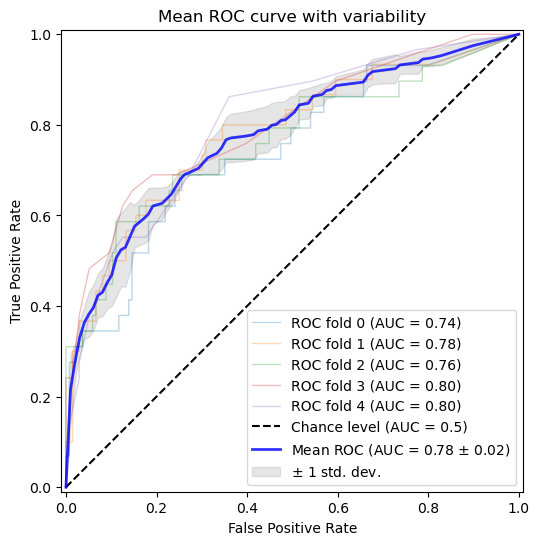

In [11]:
#Perform hyperparameter optimization and plot mean ROC curve with variability
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, optimize_knn, n_splits=5)

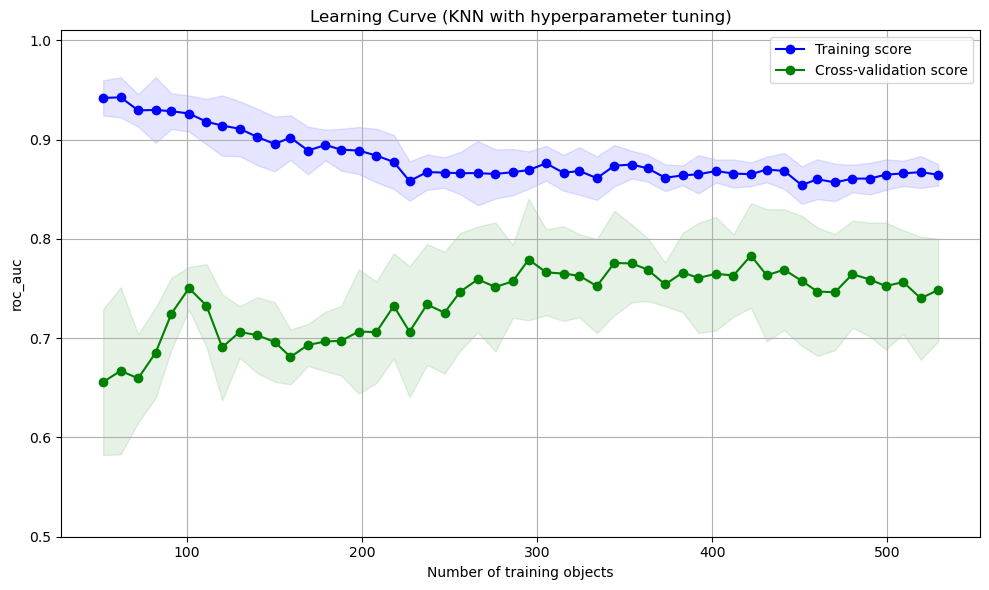

In [117]:
#plot Learning curve
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='KNN with hyperparameter tuning')

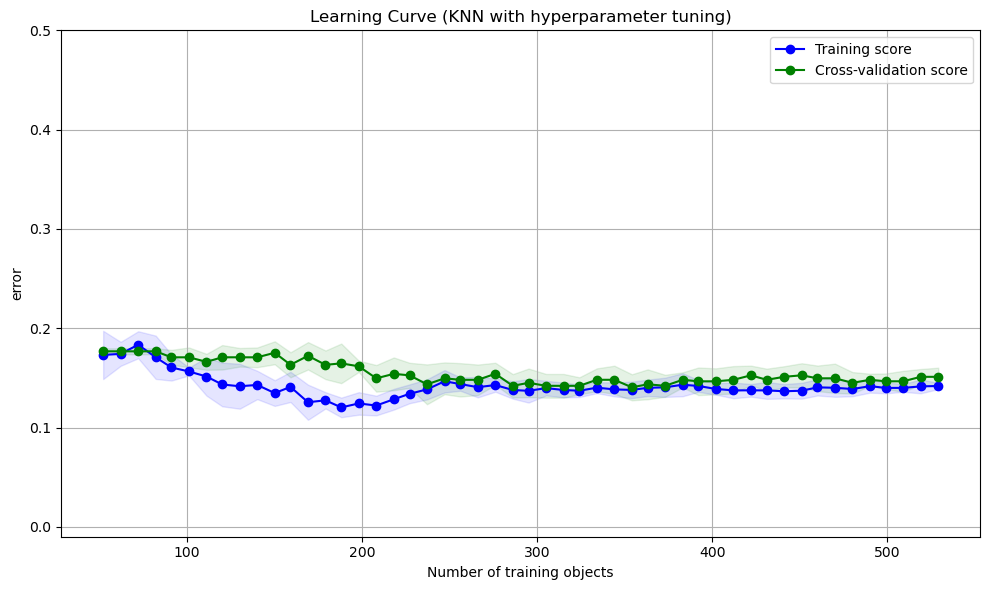

In [12]:
#plot Learning curve
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='KNN with hyperparameter tuning')

### Unused code KNN:

In [ ]:
#Optie 1: Feature selection with SelectKBest mutual_info_classif, k=100

knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])


scores = cross_val_score(
    knn,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Mean ROC AUC:", scores.mean())

plot_learning_curve(X_train, y_train, classifier=knn, scoring='error', clf_type='KNN + SelectKBest(mutual_info_classif, k=100)')


In [ ]:
#Optie 2: Feature selection: pre-feature selection (f_classif, k=200) and with SelectKBest mutual_info_classif, k=100
selector = SelectKBest(score_func=f_classif, k=200)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])


scores = cross_val_score(
    knn,
    X_train_reduced,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Mean ROC AUC:", scores.mean())

plot_learning_curve(X_train_reduced, y_train, classifier=knn, scoring='error', clf_type='KNN + pre-feature selection (f_classif, k=200)+ SelectKBest(mutual_info_classif, k=100)')


In [ ]:
#Optie 3: Feature selection with SelectKBest f_classif, k=100
knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])


scores = cross_val_score(
    knn,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1
)

print("ROC AUC scores per fold:", scores)
print("Mean ROC AUC:", scores.mean())

plot_learning_curve(X_train, y_train, classifier=knn, scoring='error', clf_type='KNN + SelectKBest(f_classif, k=100)')

In [ ]:
#Optie 2: Feature selection: pre-feature selection (f_classif, k=200) and with SelectKBest mutual_info_classif, k=100
#hyperparameter tuning with RandomizedSearchCV

selector = SelectKBest(score_func=f_classif, k=200)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

knn = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', SelectKBest(mutual_info_classif, k=100)),
    ('classifier', KNeighborsClassifier())
])

parameters = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc' ,
    random_state=42 
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best ROC_AUC Score:", model.best_score_)
print("best parameters:", model.best_params_)

plot_learning_curve(X_train, y_train, classifier=knn, scoring='error', clf_type='KNN + hyperparameter tuning with RandomizedSearchCV + pre-feature selection (f_classif, k=200)+ SelectKBest(mutual_info_classif, k=100)')


# Random Forest

For the Random Forest classifier, we decided to optimize:
- The number of features (k),
- The number of estimators (n_estimators),
- Minimum number of samples required for a split (min_samples_split), 
- Minimum number of samples required for a leaf (min_samples_leaf), 
- Maximum depth of each tree (max_depth),
- Function to measure the quality of a split (criterion), and
- Whether bootstrapping is used to train the trees (bootstrap).

In [3]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
    'feature_selection__k': np.arange(50, 500, 25),
    'classifier__n_estimators': np.arange(45, 75, 5),
    'classifier__min_samples_split': np.arange(20, 50, 5),
    'classifier__min_samples_leaf': np.arange(20, 50, 5),
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1,
                                        random_state=42
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

Best Parameters: {'feature_selection__k': 375, 'classifier__n_estimators': 60, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 30, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.8028538302629181
Accuracy:  0.819
Precision: 0.484
Recall:    0.517
F1 Score:  0.500
AUC Score: 0.797
Best Parameters: {'feature_selection__k': 325, 'classifier__n_estimators': 60, 'classifier__min_samples_split': 35, 'classifier__min_samples_leaf': 30, 'classifier__max_depth': 3, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.786707219784603
Accuracy:  0.825
Precision: 0.513
Recall:    0.667
F1 Score:  0.580
AUC Score: 0.829
Best Parameters: {'feature_selection__k': 375, 'classifier__n_estimators': 60, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 30, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.82299228825954
Accu

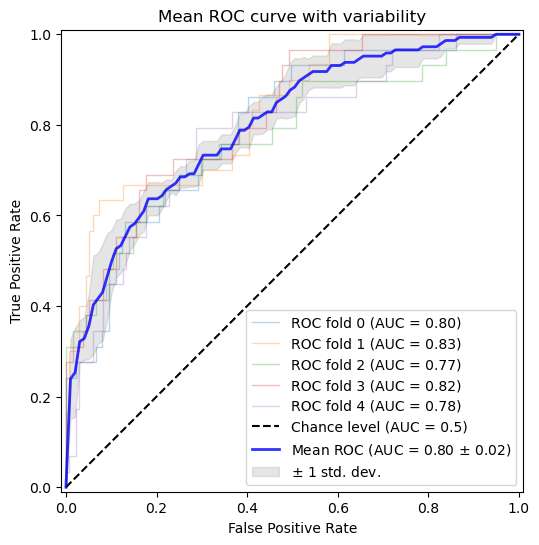

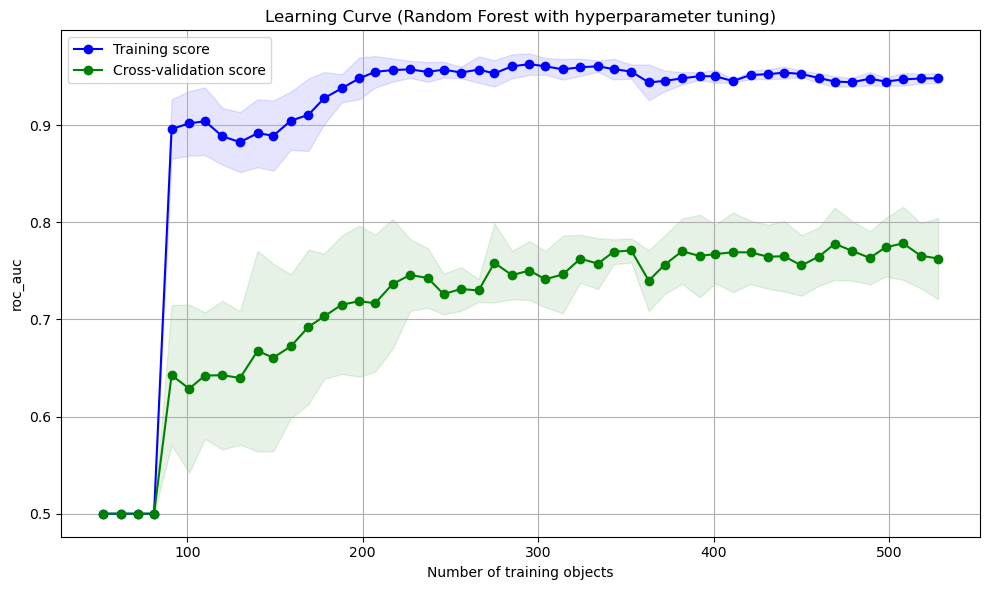

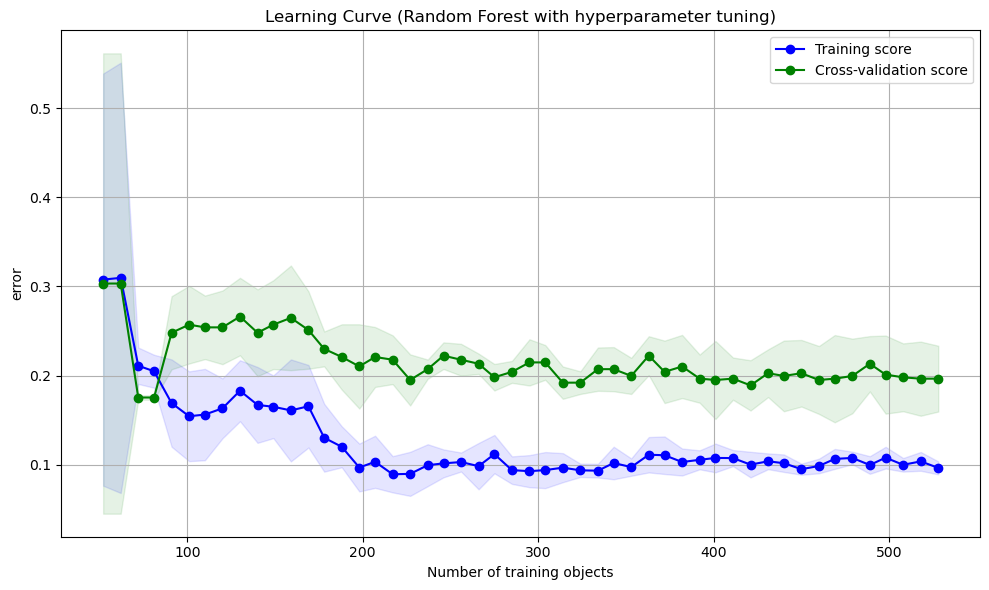

In [4]:
# Perform the hyperparameter optimization and plot the ROC curves and learning curves
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, optimize_rf, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')


## Steps for Random Forest

### Baseline RandomForest model
To check the performance of a simple model, a RandomForestClassifier with 10 estimators and a max depth of 5 was used. The same model was used to plot the AUC score vs the number of features.
The learning curve shows a minimal decrease in the cross-validation error, but a fast increase in training error. The ROC AUC score for the training set is almost always (very close to) one. This indicates that the model is likely overfit, so it has to be optimized.

In [14]:
# Make sure the data is correctly loaded and split
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

# Make cross-validation object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Mean ROC AUC: 0.6877697592717581


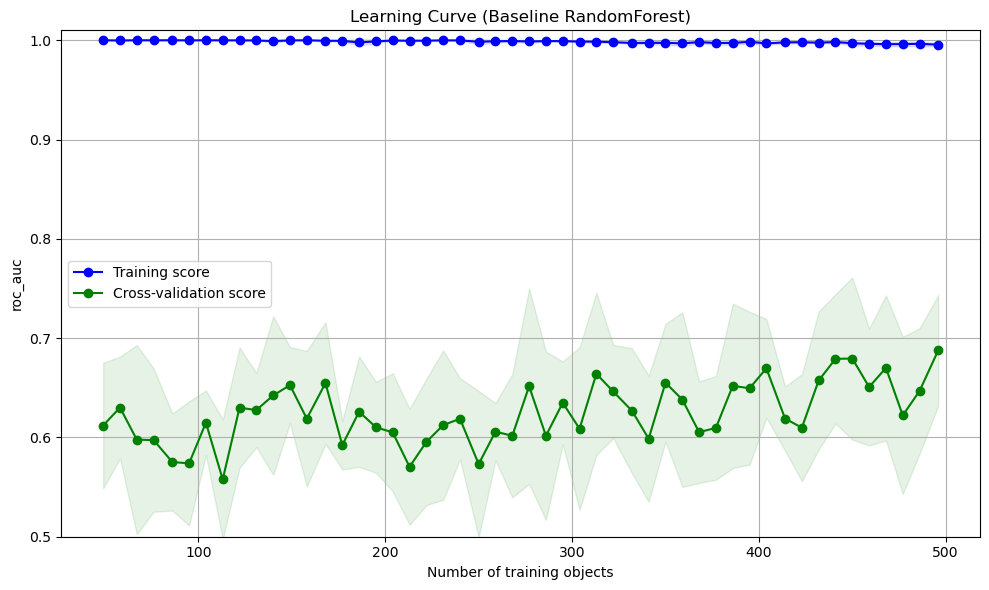

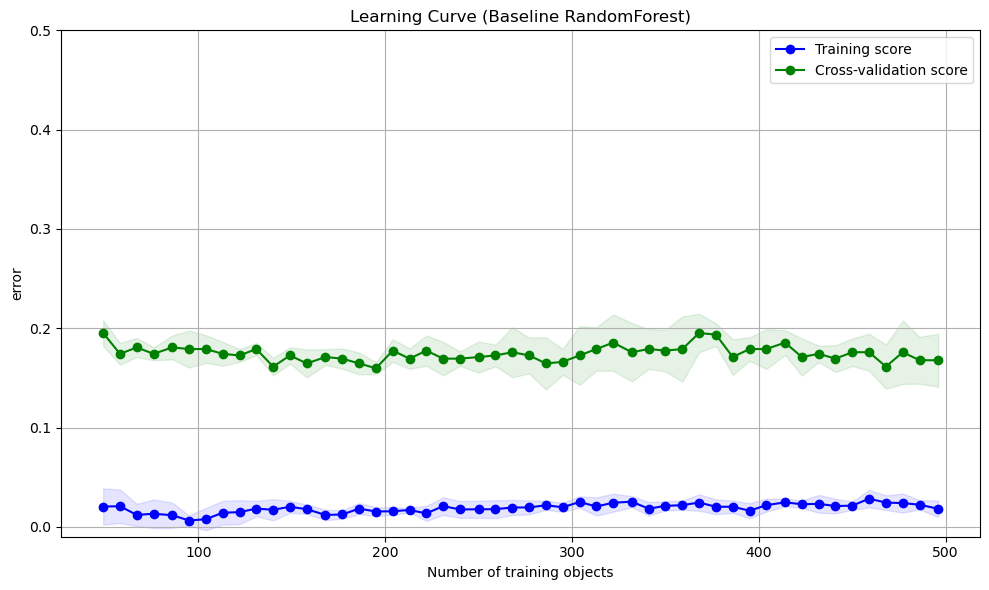

In [15]:
# Initialize and fit a basic Random Forest
rf = RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Evaluate with AUC score and learning curves
scores = cross_val_score(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Mean ROC AUC: {scores.mean()}")

plot_learning_curve(X_train, y_train, rf, scoring='roc_auc', clf_type='Baseline RandomForest')
plot_learning_curve(X_train, y_train, rf, scoring='error', clf_type='Baseline RandomForest')


Since the dataset contains 9000 features, it is likely that a large part of the features in the dataset contains no useful information. 
If RF randomly selects these irrelevant features, we would introduce noise to our model and thus decrease the model performance. 
To test this, the area under the receiver operating characteristics curve (ROC AUC) score was plotted for different numbers of features, 
using a simple RF classifier (n_estimators=10, max_depth=5).

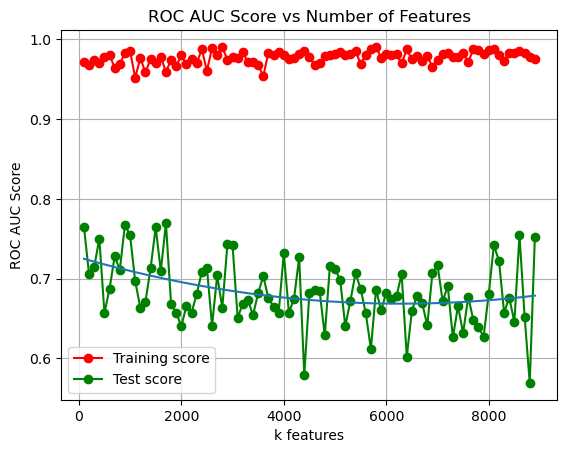

In [ ]:
train_scores = []
test_scores = []
k_list = np.arange(100,9000,100)

# For each k features in the list, train a RF classifier and calculate the AUC score
for k in k_list:
    rf = Pipeline([
                ('feature_selection', SelectKBest(f_classif, k=k)), 
                ('rfc', RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1, random_state=42))
                ])
    rf.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
    test_scores.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# Fit a trendline through the points of the test scores (since that is what we're interested in)
poly = np.polyfit(k_list, test_scores, deg=2)
poly_func = np.poly1d(poly)

k_smooth = np.linspace(k_list.min(), k_list.max(), 300)
test_scores_smooth = poly_func(k_smooth)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.plot(k_list, train_scores, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores, 'o-', color="g",
        label="Test score")
ax.plot(k_smooth, test_scores_smooth)
ax.set_title('ROC AUC Score vs Number of Features')
ax.set_xlabel('k features')
ax.set_ylabel('ROC AUC Score')
ax.legend()


From the above plot, it is clear that reducing the amount of features increases the ROC AUC score. From this, we can set a preliminary threshold of 1000 features and tune the exact amount of features later, as a hyperparameter.

Mean ROC AUC: 0.6877697592717581


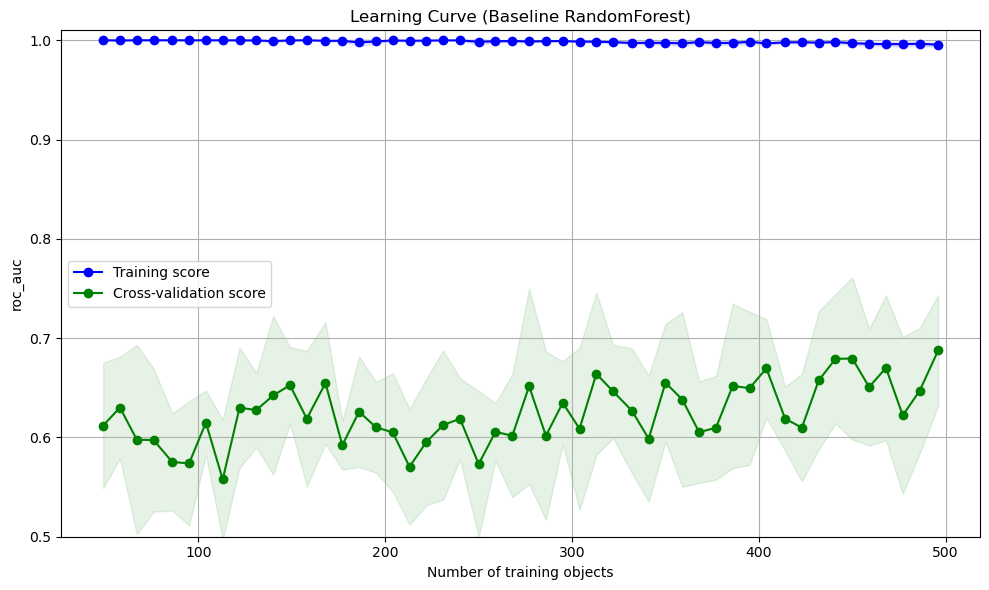

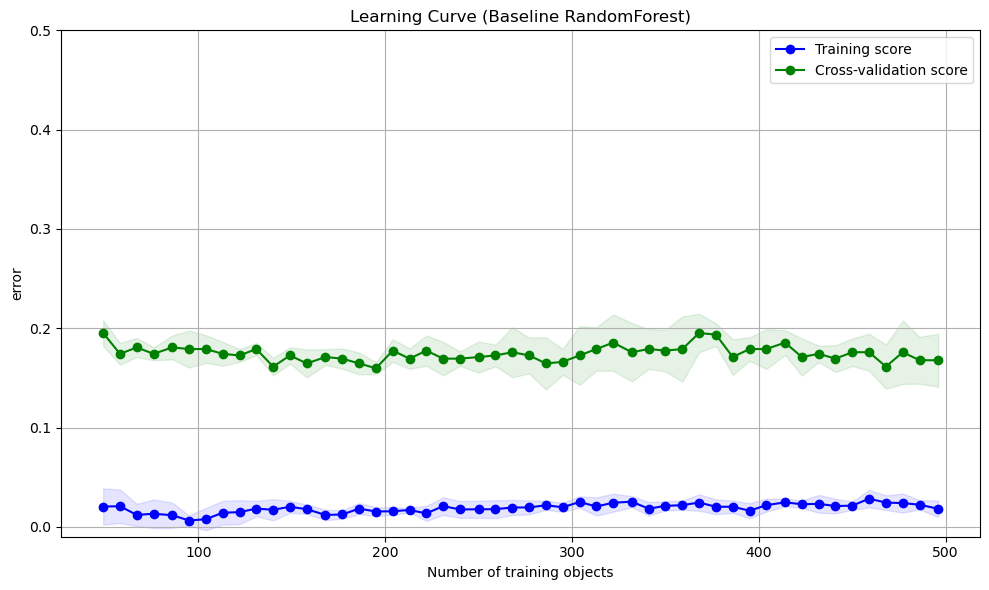

In [16]:
# Initialize and fit a basic Random Forest with 1000 features as input
selector = SelectKBest(f_classif, k=1000)
X_selected = selector.fit_transform(X_train, y_train)

rf = RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1, random_state=42, class_weight='balanced')
rf.fit(X_selected, y_train)

# Evaluate with AUC score and learning curves
scores = cross_val_score(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Mean ROC AUC: {scores.mean()}")

plot_learning_curve(X_train, y_train, rf, scoring='roc_auc', clf_type='Baseline RandomForest')
plot_learning_curve(X_train, y_train, rf, scoring='error', clf_type='Baseline RandomForest')


Next, we want to see what range of n_estimators is optimal for our model to minimise variance, while keeping computational power as low as possible

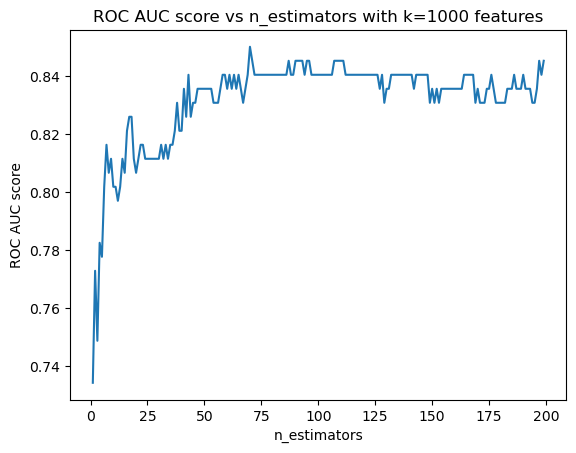

In [ ]:
# Using k=1000 features and the baseline classifier, plot the ROC AUC score against n_estimators
scores =[]
for n in range(1, 200):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif, k=1000)), 
                 ('classifier', RandomForestClassifier(n_estimators=n, max_depth=5, n_jobs=-1, random_state=42, class_weight='balanced'))
                 ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))


# plot the relationship between n_estimators and ROC AUC score
plt.plot(range(1, 200), scores)
plt.title("ROC AUC score vs n_estimators with k=1000 features")
plt.xlabel('n_estimators')
plt.ylabel('ROC AUC score')
plt.show()

Looking at the plot above, it seems that n_estimators above 75 does not improve the AUC score any further, so we set n_estimators to be optimized in the range of 45 to 75.

Mean ROC AUC: 0.7416677173958728


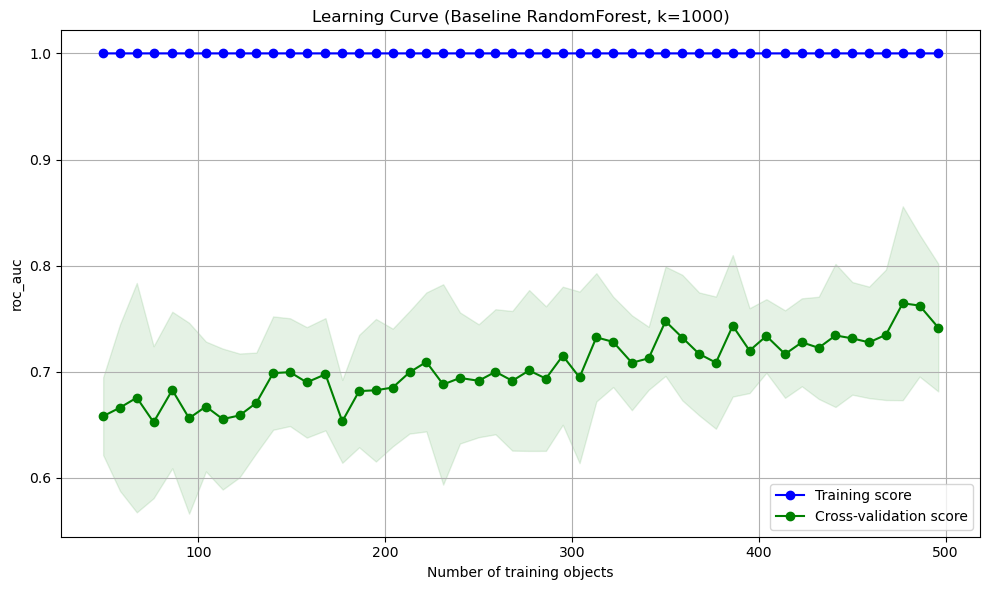

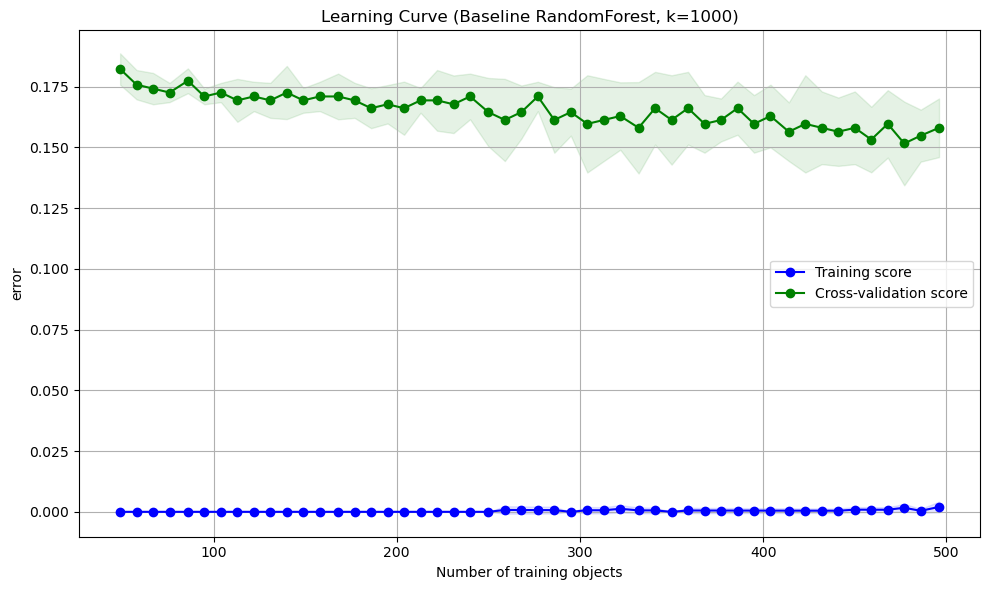

In [ ]:
# Initialize and fit a basic Random Forest with 1000 features as input, with n_estimators limited to 75
selector = SelectKBest(f_classif, k=1000)
X_selected = selector.fit_transform(X_train, y_train)

rf = RandomForestClassifier(n_estimators=75, max_depth=5, n_jobs=-1, random_state=42, class_weight='balanced')
rf.fit(X_selected, y_train)

# Evaluate with AUC score and learning curves
scores = cross_val_score(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Mean ROC AUC: {scores.mean()}")

plot_learning_curve(X_train, y_train, rf, scoring='roc_auc', clf_type='Baseline RandomForest, k=1000')
plot_learning_curve(X_train, y_train, rf, scoring='error', clf_type='Baseline RandomForest, k=1000')

Based on the considerations mentioned above for n_features and n_estimators, a first prototype for hyperparameter optimization was created:

Best Parameters: {'feature_selection__k': 600, 'classifier__n_estimators': 45, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 15, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
Best Score: 0.8125920624207318
Mean ROC AUC: 0.7951711885107087


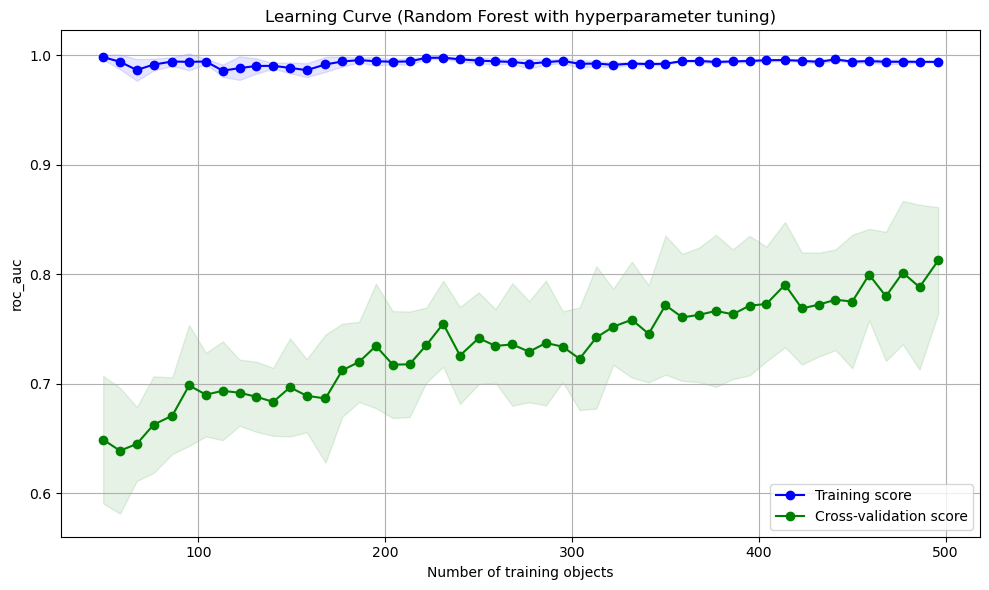

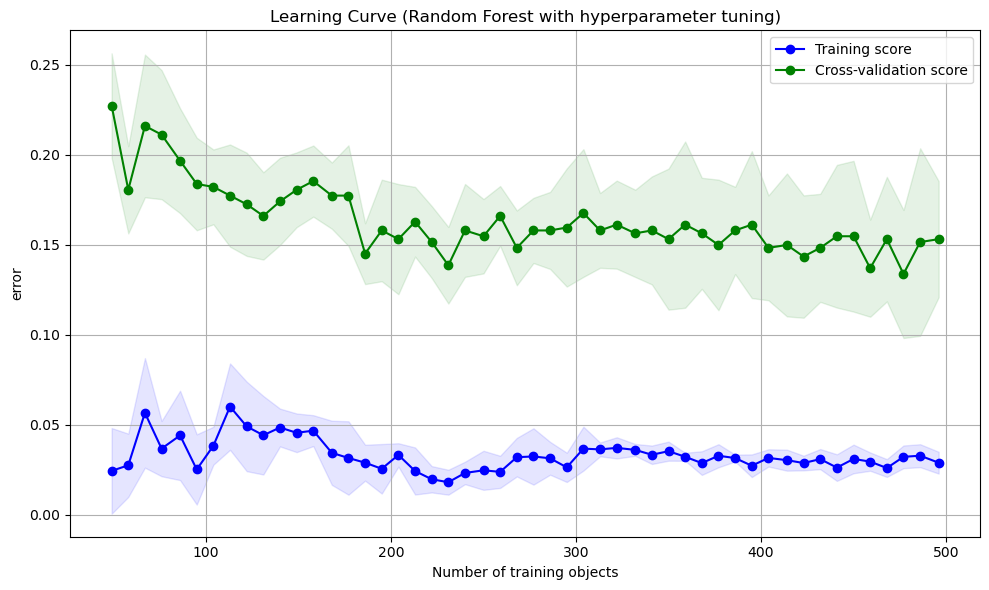

In [ ]:
# First model that was used with hyperparameter optimization
pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                ])

param_dist = {
    'feature_selection__k': np.arange(100, 1000, 50),
    'classifier__n_estimators': np.arange(45, 75, 5),
    'classifier__min_samples_split': [5, 10, 15],
    'classifier__min_samples_leaf': [5, 10, 15],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__bootstrap': [True, False]
}

n_iterations = 20

random_search = RandomizedSearchCV(
                                    pipe, 
                                    param_distributions=param_dist, 
                                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                    n_iter=n_iterations,
                                    scoring='roc_auc', 
                                    n_jobs=-1,
                                    random_state=42
                                    )
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
print(f"Mean ROC AUC: {random_search.cv_results_['mean_test_score'].mean()}")

plot_learning_curve(X_train, y_train, classifier=random_search.best_estimator_, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, classifier=random_search.best_estimator_, scoring='error', clf_type='Random Forest with hyperparameter tuning')


Best Parameters: {'feature_selection__k': 500, 'classifier__n_estimators': 70, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.7828579976067012
Mean ROC AUC: 0.772281279085228


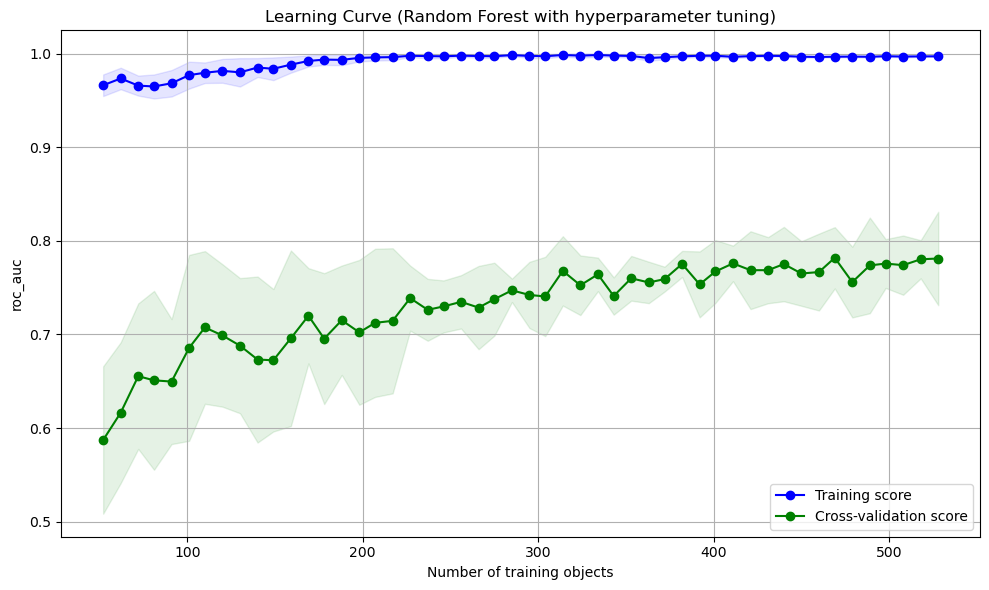

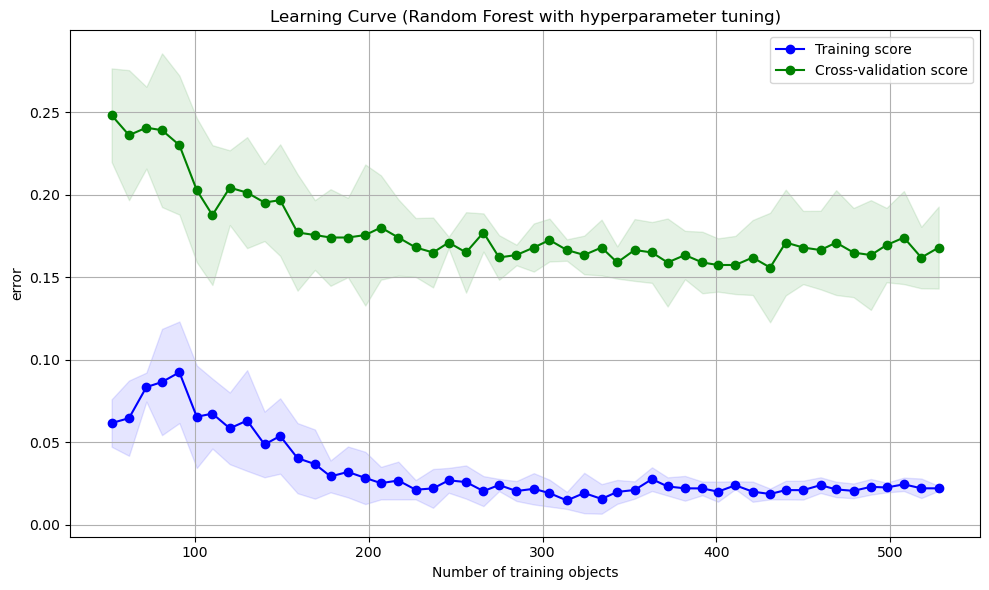

In [ ]:
# Previous model still shows overfitting, so the model's complexity was limited by:
# increasing the min_samples_split and *_leaf to a minimum of 10 samples, and limiting the max_depth to 10
pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                ])

param_dist = {
    'feature_selection__k': np.arange(100, 1000, 50),
    'classifier__n_estimators': np.arange(45, 75, 5),
    'classifier__min_samples_split': np.arange(10, 30, 5),
    'classifier__min_samples_leaf': np.arange(10, 30, 5),
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__bootstrap': [True, False]
}

n_iterations = 20

random_search = RandomizedSearchCV(
                                    pipe, 
                                    param_distributions=param_dist, 
                                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                    n_iter=n_iterations,
                                    scoring='roc_auc', 
                                    n_jobs=-1,
                                    random_state=42
                                    )
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
print(f"Mean ROC AUC: {random_search.cv_results_['mean_test_score'].mean()}")

plot_learning_curve(X_train, y_train, classifier=random_search.best_estimator_, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, classifier=random_search.best_estimator_, scoring='error', clf_type='Random Forest with hyperparameter tuning')


To further optimize the model to reduce overfitting, it was decided to reduce the amount of features (based on the fact that 
lower number of features are consistently being selected by the randomized search),
and increase the min_samples_split and *_leaf further.

The results still show overfitting. However, reducing the complexity even further would increase the variance and decrease the performance
significantly. Based on this, it was decided that either the Random Forest classifier is not suitable for this dataset, or that the method
of feature selection was suboptimal for this classifier.

It is hypothesized that a feature selection based on the built-in feature importance of Random Forest could improve the model's generalizability.

Best Parameters: {'feature_selection__k': 325, 'classifier__n_estimators': 60, 'classifier__min_samples_split': 35, 'classifier__min_samples_leaf': 35, 'classifier__max_depth': 3, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.7896788990825689
Mean ROC AUC: 0.7692914838452334


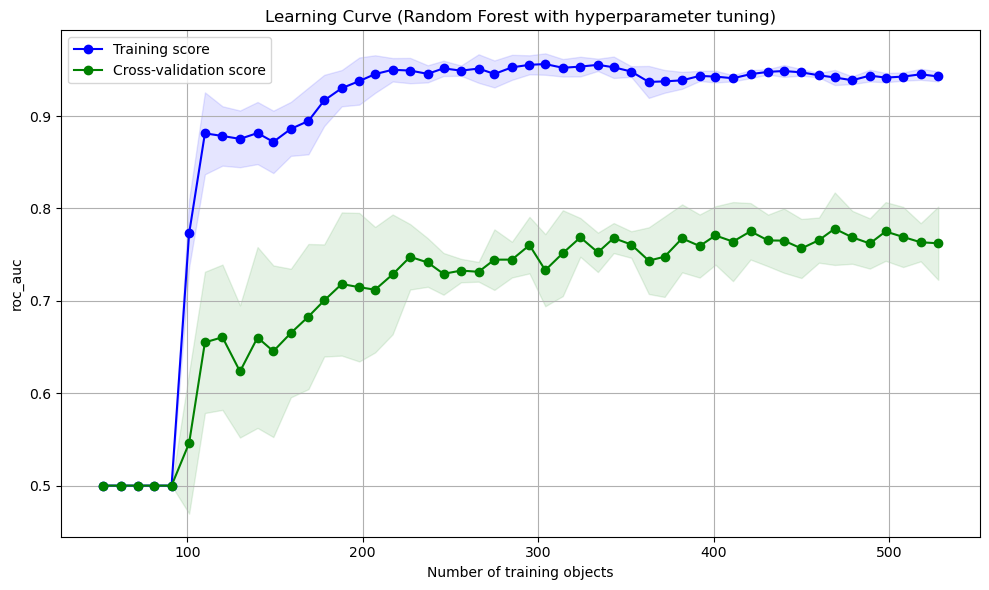

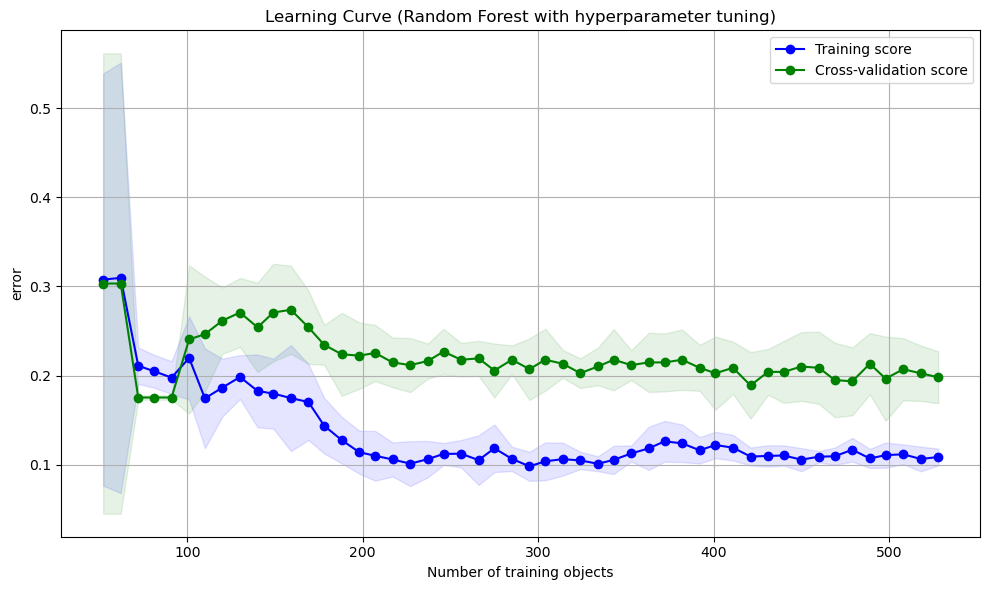

In [ ]:
pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                ])

param_dist = {
    'feature_selection__k': np.arange(50, 500, 25),
    'classifier__n_estimators': np.arange(45, 75, 5),
    'classifier__min_samples_split': np.arange(20, 40, 5),
    'classifier__min_samples_leaf': np.arange(20, 40, 5),
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__bootstrap': [True, False]
}

n_iterations = 20

random_search = RandomizedSearchCV(
                                    pipe, 
                                    param_distributions=param_dist, 
                                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                    n_iter=n_iterations,
                                    scoring='roc_auc', 
                                    n_jobs=-1,
                                    random_state=42
                                    )
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
print(f"Mean ROC AUC: {random_search.cv_results_['mean_test_score'].mean()}")

plot_learning_curve(X_train, y_train, classifier=random_search.best_estimator_, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, classifier=random_search.best_estimator_, scoring='error', clf_type='Random Forest with hyperparameter tuning')
